In [21]:
import os, sys
import warnings
warnings.filterwarnings("ignore")

import scanpy as sc
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl


In [2]:
path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/'
table_path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/results/tables/'
figure_path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/results/figures/'

adata = sc.read_h5ad(path+'data/lung_organoid_all_original_filtered_022024_5.h5ad')
adata = adata[(adata.obs.high_quality == 'True') &
                (adata.obs.treated != 'RMC-113') &
                ~(adata.obs.ID.isin(['24h infected RMC113', '24h infected DMSO'])) 
                ].copy()


In [3]:
adata.obs.ID.cat.categories

Index(['2h_infected_DMSO', '2h_infected_Lapatinib', '2h_uninfected_DMSO',
       '2h_uninfected_Lapatinib', '4h infected DMSO', '4h uninfected DMSO',
       '8h_infected_DMSO', '8h_infected_Lapatinib', '8h_uninfected_Lapatinib',
       '12h_infected_DMSO', '16h_infected_DMSO', '24h uninfected DMSO',
       '24h_infected_DMSO', '24h_infected_Lapatinib',
       '24h_uninfected_Lapatinib'],
      dtype='object')

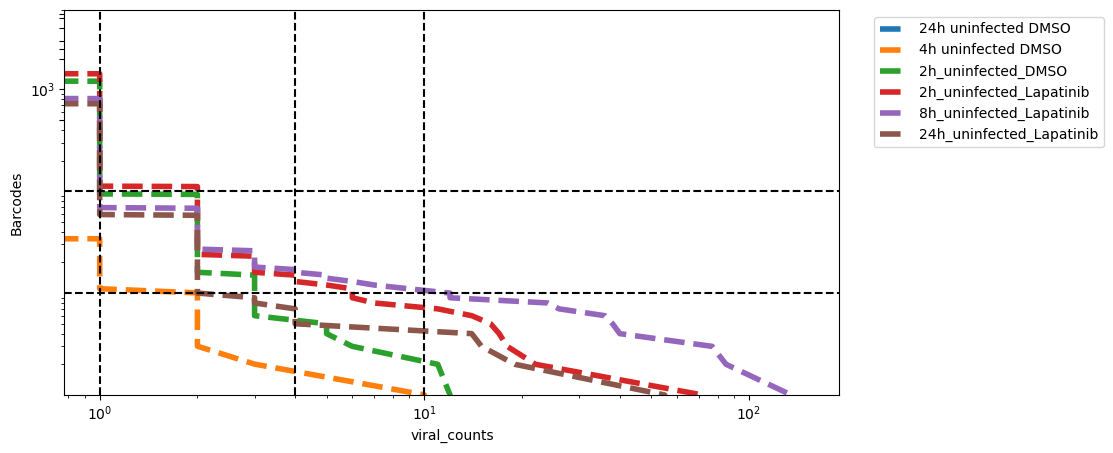

In [4]:
### Non-specific vRNA reads in uninfected samples
### So we need to eliminate false positive vRNA harboring cells
### We set a light threshold in RMC-113 paper as 
### VHCs contatining at least 4 (>3) vRNA reads
yid='viral_counts'
plt.rcParams["figure.figsize"] = (10,5)
fig, ax = plt.subplots()
for s in [x for x in adata.obs.ID.unique() if 'uninfected' in x]:
    adata_ct = adata[adata.obs['ID'] == s].copy()
    m='solid'
    if 'uninfected' in s:
        m='dashed'
    x = adata_ct.obs[yid].copy()
    x = np.sort(x)
    y = np.linspace(len(x), 0, len(x))
    #y=1-np.linspace(0,1,len(x))
    ax.plot(x,y,label=s,lw=4, linestyle=m)

ax.axvline(x=10, c='black', ls='--')
ax.axvline(x=4, c='black', ls='--')
ax.axvline(x=1, c='black', ls='--')
ax.axhline(y=10, c='black', ls='--')
ax.axhline(y=100, c='black', ls='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_yticks([0, 500, 1000, 2000, 2500,3000,4000, 5000, 5500])
ax.set_ylim(-50, 6000)
ax.set_ylabel('Barcodes')
ax.set_xlabel(yid)
ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0))


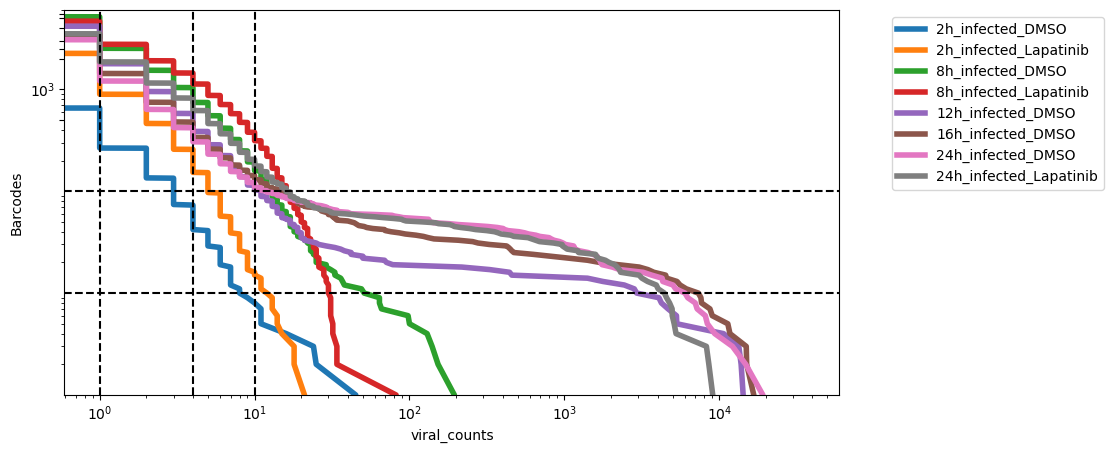

In [5]:
### infected samples only
yid='viral_counts'
plt.rcParams["figure.figsize"] = (10,5)
fig, ax = plt.subplots()
for s in [x for x in adata.obs.ID.unique() if '_infected' in x]:
    adata_ct = adata[adata.obs['ID'] == s].copy()
    m='solid'
    if 'uninfected' in s:
        m='dashed'
    x = adata_ct.obs[yid].copy()
    x = np.sort(x)
    y = np.linspace(len(x), 0, len(x))
    #y=1-np.linspace(0,1,len(x))
    ax.plot(x,y,label=s,lw=4, linestyle=m)

ax.axvline(x=10, c='black', ls='--')
ax.axvline(x=4, c='black', ls='--')
ax.axvline(x=1, c='black', ls='--')
ax.axhline(y=10, c='black', ls='--')
ax.axhline(y=100, c='black', ls='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_yticks([0, 500, 1000, 2000, 2500,3000,4000, 5000, 5500])
ax.set_ylim(-50, 6000)
ax.set_ylabel('Barcodes')
ax.set_xlabel(yid)
ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0))


In [4]:
adata.obs.new_cell_type.cat.categories

Index(['AT1', 'AT2', 'Basal', 'NGFR-HOPX-CEACAM6+'], dtype='object')

In [5]:
adata.obs.new_cell_type.cat.add_categories(['AT1-like cells', 'AT2-like cells', 'Basal-like cells'], inplace=True)
adata.obs.loc[adata[adata.obs.new_cell_type == 'AT1'].obs_names, 'new_cell_type'] = 'AT1-like cells'
adata.obs.loc[adata[adata.obs.new_cell_type == 'AT2'].obs_names, 'new_cell_type'] = 'AT2-like cells'
adata.obs.loc[adata[adata.obs.new_cell_type == 'Basal'].obs_names, 'new_cell_type'] = 'Basal-like cells'
adata.obs.new_cell_type.cat.remove_unused_categories(inplace=True)

In [6]:
adata.obs.new_cell_type.cat.reorder_categories(['AT2-like cells', 'AT1-like cells', 'NGFR-HOPX-CEACAM6+', 'Basal-like cells'], ordered=True, inplace=True)


In [7]:
adata.obs.sort_values(by='viral_counts').tail(100).groupby('new_cell_type').size()


new_cell_type
AT2-like cells        92
AT1-like cells         5
NGFR-HOPX-CEACAM6+     0
Basal-like cells       3
dtype: int64

In [8]:
adata.obs['bystanders'] = 'low'
adata.obs.loc[adata.obs.viral_counts==0, 'bystanders'] = 'zero'
adata.obs.loc[adata.obs.viral_counts>3, 'bystanders'] = 'high'
adata.obs.loc[adata.obs.infected == 'False', 'bystanders'] = 'uninfected'

pd.crosstab(adata.obs.bystanders, adata.obs.new_cell_type)

new_cell_type  AT2-like cells  AT1-like cells  NGFR-HOPX-CEACAM6+  \
bystanders                                                          
high                     3030            1114                 139   
low                      5968            4504                1458   
uninfected               7069           11159                3933   
zero                     6800            6455                3558   

new_cell_type  Basal-like cells  
bystanders                       
high                        856  
low                        9917  
uninfected                34528  
zero                      31044

Text(0, 0.5, '')

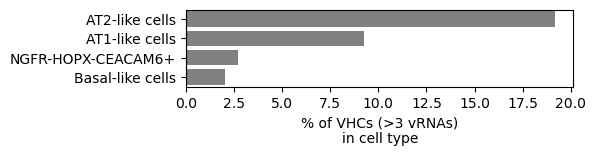

In [39]:
df = pd.DataFrame(adata.obs.groupby(['infected', 'new_cell_type', 'bystanders'])['run'].count())
df = df.loc['True']
df['total'] = [df.reset_index().groupby(['new_cell_type']).sum().loc[x][0] for x in df.reset_index()['new_cell_type']]
df['% of VHCs (>3 vRNAs)\nin cell type'] = df['run']*100/df['total']
df = df.reset_index()[df.reset_index()['bystanders'] == 'high'][['new_cell_type', '% of VHCs (>3 vRNAs)\nin cell type']]
df = df.sort_values(by='% of VHCs (>3 vRNAs)\nin cell type', ascending=False)
fig, ax = plt.subplots(figsize=(5,1))
sns.barplot(data=df, y='new_cell_type', x='% of VHCs (>3 vRNAs)\nin cell type', 
            ax = ax,
            order=['AT2-like cells', 'AT1-like cells', 'NGFR-HOPX-CEACAM6+', 'Basal-like cells'],
            palette= ['gray', 'gray', 'gray', 'gray'],
           #palette= ['#9e0142', '#fdbf6f', '#bfe5a0', '#5e4fa2', ]
)
ax.set_ylabel('')


In [9]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

# Save raw expression values before variable gene subset
adata.raw = adata.copy()
adata.layers['raw'] = adata.X.copy()

sc.pp.filter_genes(adata, min_cells=3)


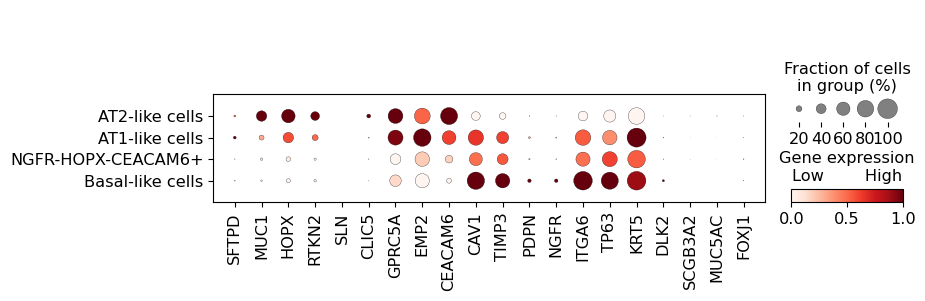

In [43]:
plt.rcParams['font.size']= 14
genes_short = ['SFTPD', 'MUC1', 'HOPX', 'RTKN2', 'SLN', 'CLIC5', 
               'GPRC5A', 'EMP2', 'CEACAM6', 'CAV1', 'TIMP3', 'PDPN',
              'NGFR', 'ITGA6', 'TP63','KRT5', 'DLK2',
              'SCGB3A2', 'MUC5AC', 'FOXJ1',]

sc.pl.dotplot(adata, genes_short, groupby='new_cell_type', use_raw=True, standard_scale='var', colorbar_title='Gene expression\nLow        High',
              )


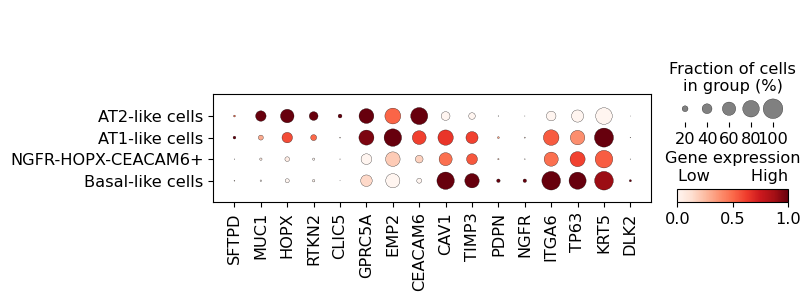

In [44]:
plt.rcParams['font.size']= 14
genes_short = ['SFTPD', 'MUC1', 'HOPX', 'RTKN2', 'CLIC5', 
               'GPRC5A', 'EMP2', 'CEACAM6', 'CAV1', 'TIMP3', 'PDPN',
              'NGFR', 'ITGA6', 'TP63','KRT5', 'DLK2',]

sc.pl.dotplot(adata, genes_short, groupby='new_cell_type', use_raw=True, standard_scale='var', colorbar_title='Gene expression\nLow        High',
              )


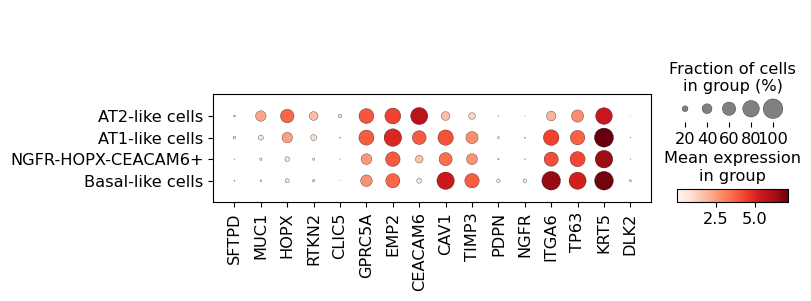

In [45]:
sc.pl.dotplot(adata, genes_short, groupby='new_cell_type', use_raw=True, 
              #standard_scale='var', colorbar_title='Gene expression\nLow        High',
              )


import matplotlib.pyplot as plt
plt.rcParams['font.size']= 20

sc.pp.highly_variable_genes(adata, n_top_genes =2000, batch_key='ID')
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

sc.pl.umap(adata, color=['tpi', 'bystanders', 'new_cell_type', 
                           'infected', 'treated', 'viral_CPM'], wspace=0.4, ncols=3)

sc.pl.umap(adata, color=['MUC1', 'LAMP3', 'SFTPD', 'SFTPB', 'cell_type', 
                            'CEACAM6', 'RTKN2', 'ETV5', 'HOPX', 'new_cell_type',
                            'PDPN', 'CAV1', 'TIMP3', 'AGER', 'total_counts', 
                            'NGFR', 'KRT5', 'KRT15', 'ITGA6', 'n_genes_by_counts', 
                            'MUC5AC', 'MUC5B', 'SPDEF', 'TFF3', 'pct_counts_mt', 
                            'SCGB1A1', 'CTSE', 'FOXJ1', 'viral_CPM', 'bystanders'], wspace=0.4, ncols=5, cmap='coolwarm')


In [47]:
import matplotlib.pyplot as plt
plt.rcParams['font.size']= 20

sc.pp.highly_variable_genes(adata, n_top_genes =2000, batch_key='ID')
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
X_umap = adata.obsm['X_umap'].copy()

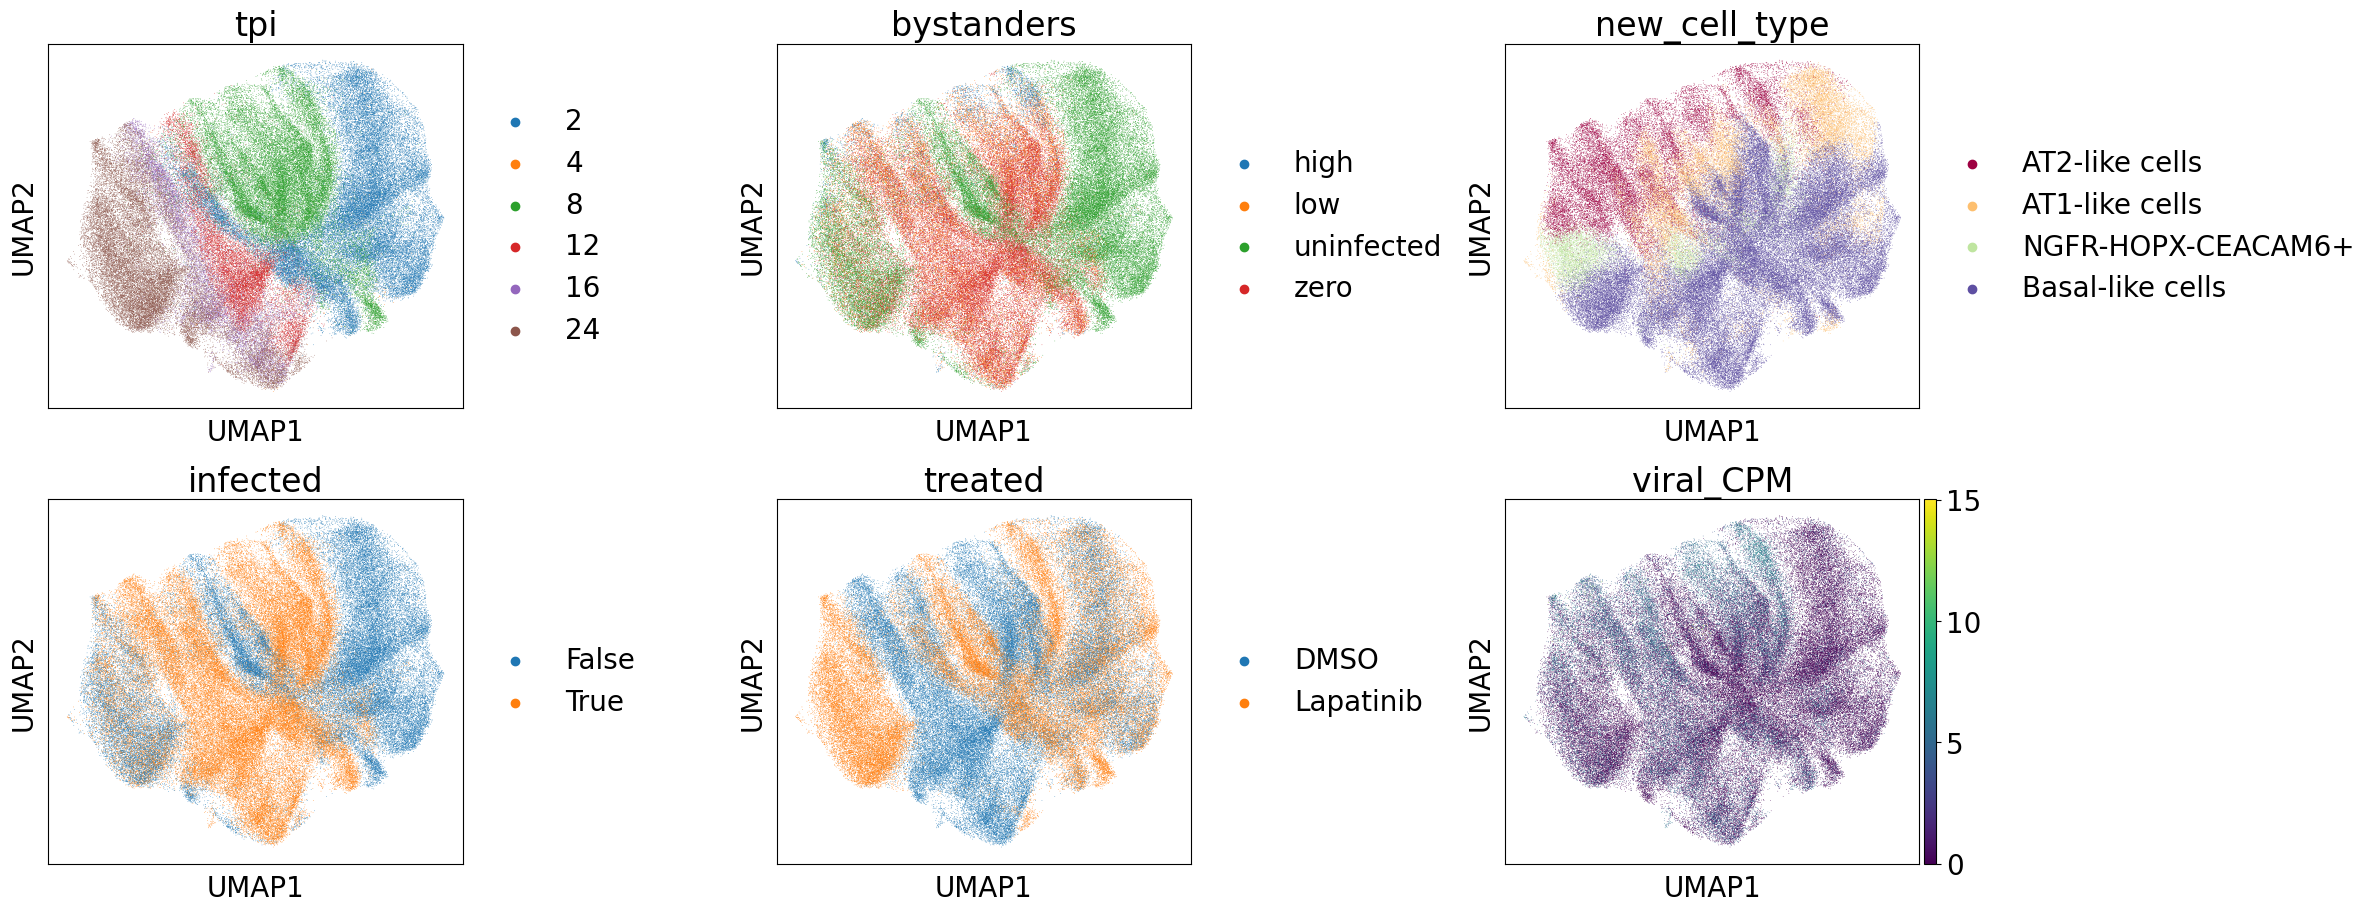

In [247]:
plt.rcParams['font.size']= 20
plt.rcParams['figure.figsize']= [5,5]
adata.obsm['X_umap'] = X_umap.copy()
sc.pl.umap(adata, color=['tpi', 'bystanders', 'new_cell_type', 
                           'infected', 'treated', 'viral_CPM'], wspace=0.6, ncols=3)


sc.external.pp.harmony_integrate(adata, 'ID', basis='X_pca', adjusted_basis='X_pca_harmony')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep = 'X_pca_harmony')
sc.tl.umap(adata)

sc.pl.umap(adata, color=['tpi', 'bystanders', 'new_cell_type', 
                           'infected', 'treated', 'viral_CPM'], wspace=0.4, ncols=3)

sc.pl.umap(adata, color=['MUC1', 'LAMP3', 'SFTPD', 'SFTPB', 'cell_type', 
                            'CEACAM6', 'RTKN2', 'ETV5', 'HOPX', 'new_cell_type',
                            'PDPN', 'CAV1', 'TIMP3', 'AGER', 'total_counts', 
                            'NGFR', 'KRT5', 'KRT15', 'ITGA6', 'n_genes_by_counts', 
                            'MUC5AC', 'MUC5B', 'SPDEF', 'TFF3', 'pct_counts_mt', 
                            'SCGB1A1', 'CTSE', 'FOXJ1', 'viral_CPM', 'bystanders'], wspace=0.4, ncols=5, cmap='coolwarm')


In [49]:
sc.external.pp.harmony_integrate(adata, 'ID', basis='X_pca', adjusted_basis='X_pca_harmony')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep = 'X_pca_harmony')
sc.tl.umap(adata)
X_umap_harmony = adata.obsm['X_umap'].copy()

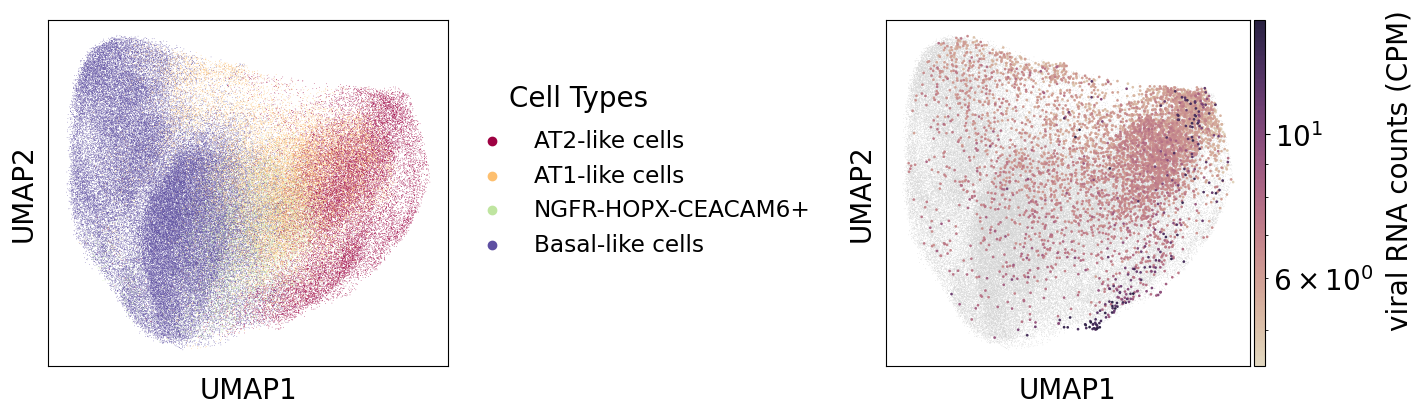

In [57]:
import matplotlib as mpl
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,4.5])
adata.uns['new_cell_type_colors'] = ['#9e0142', '#fdbf6f', '#bfe5a0', '#5e4fa2', ]
sc.pl.umap(adata, color=['new_cell_type',], 
           legend_fontsize='small', show=False, title='', ax=ax1)
ax1.text(1.5, 0.75, 'Cell Types', fontsize='medium',
        rotation='horizontal',
        horizontalalignment='right', transform=ax1.transAxes)


palette = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
# Plot all cells as background
sc.pl.umap(adata, show=False, ax=ax2)
# Plot on top viral_CPM by subsetting data with viral reads >3
sc.pl.umap(adata[(adata.obs.viral_counts>3) ],color='viral_CPM', title='', 
            ax=ax2, cmap=palette, show=False, s=15, norm=mpl.colors.LogNorm())
ax2.text(1.45, 0.12, 'viral RNA counts (CPM)', fontsize='medium',
        rotation='vertical',
        horizontalalignment='right', transform=ax2.transAxes)

fig.tight_layout(pad=1)
#plt.savefig(figure_path+'vRNA_and_ct_umaps_min_vRNA_4_CPM.svg', format="svg")
plt.show()

In [ ]:
adata_id = adata[adata.obs.cell_type == 'Basal-like cells']
sc.tl.rank_genes_groups(adata_id, f'leiden_r{res}', method='wilcoxon', use_raw=True, key_added="deg_leiden")

sc.tl.filter_rank_genes_groups(
    adata_id,
    min_in_group_fraction=0.25,
    min_fold_change = 0.25,
    max_out_group_fraction=1,
    key="deg_leiden",
    key_added="deg_leiden_filtered",
)


sc.pl.rank_genes_groups_dotplot(
    adata_id,
    groupby=f'leiden_r{res}',
    standard_scale="var",
    n_genes=10,
    key="deg_leiden_filtered",
)

#pd.DataFrame(adata_id.uns['deg_leiden_filtered']['names']).head(20)   

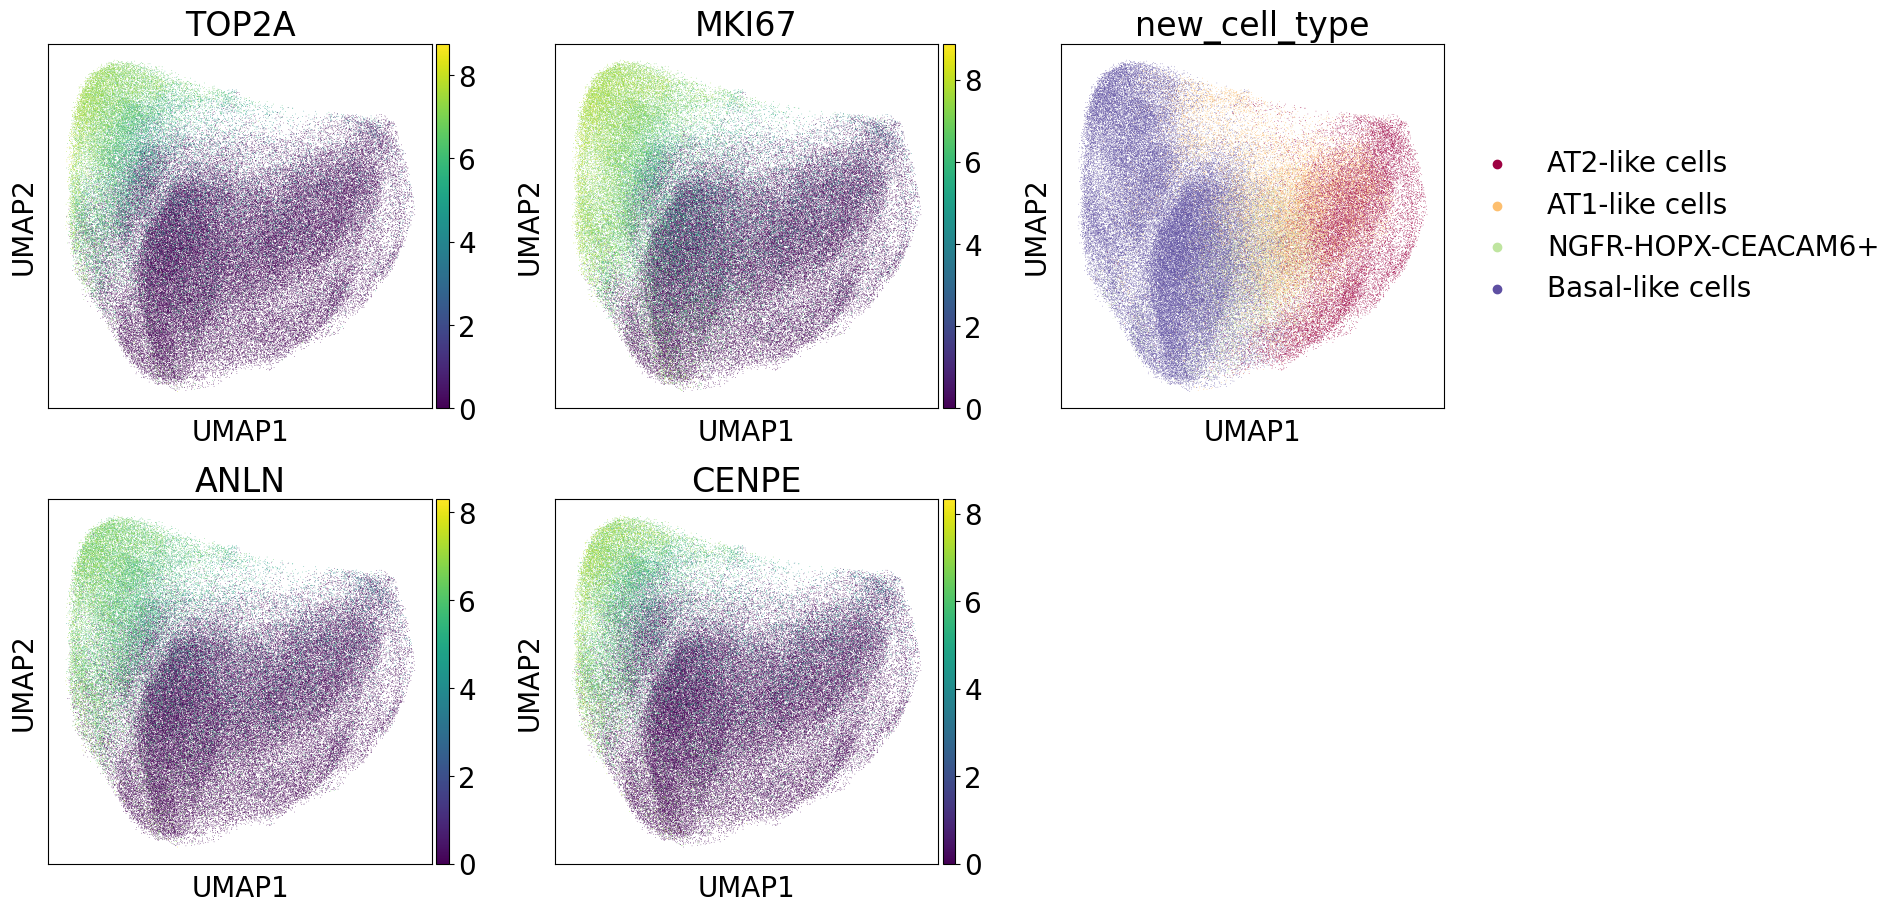

In [249]:
adata.obsm['X_umap'] = X_umap_harmony.copy()
sc.pl.umap(adata, 
           color=['TOP2A', 'MKI67', 'new_cell_type',
                 'ANLN', 'CENPE', ], 
           wspace=0.2, ncols=3)


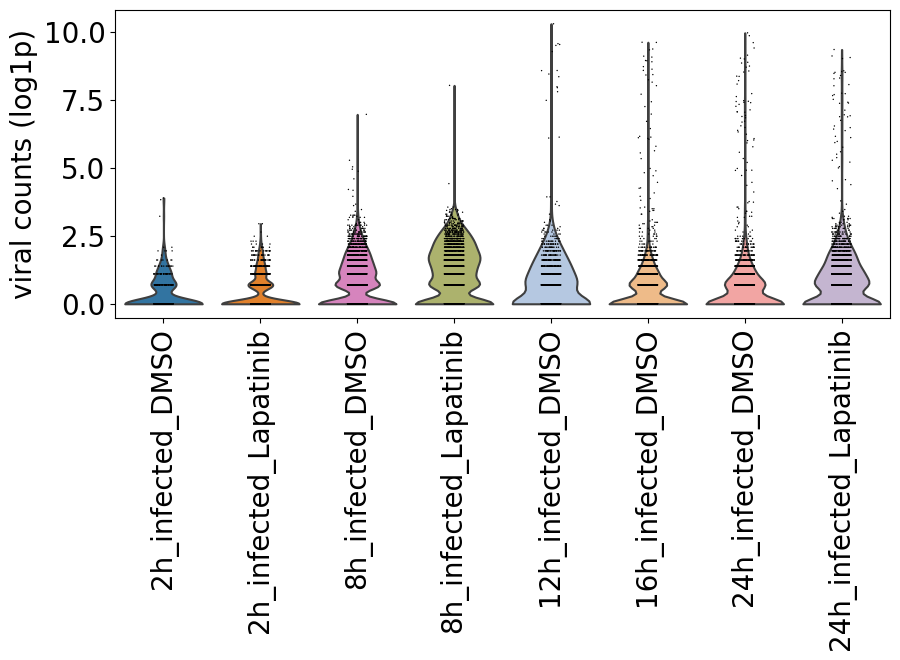

In [22]:
### all cells, includes lots of cells with zero viral RNAs

groupby_order = ['2h_infected_DMSO', '2h_infected_Lapatinib',
                '8h_infected_DMSO', '8h_infected_Lapatinib', 
                '12h_infected_DMSO', '16h_infected_DMSO',
                '24h_infected_DMSO', '24h_infected_Lapatinib',
                ]
ct = 'AT2-like cells'
adata_ct = adata[adata.obs.new_cell_type==ct]
adata_ct.obs['viral counts (log1p)'] = np.log1p(adata_ct.obs['viral_counts'])
fig, ax = plt.subplots(1, 1, figsize=(10,4),)
sc.pl.violin(adata_ct, keys='viral counts (log1p)', groupby='ID', rotation=90,
    order=groupby_order, ax=ax
            )
plt.show()

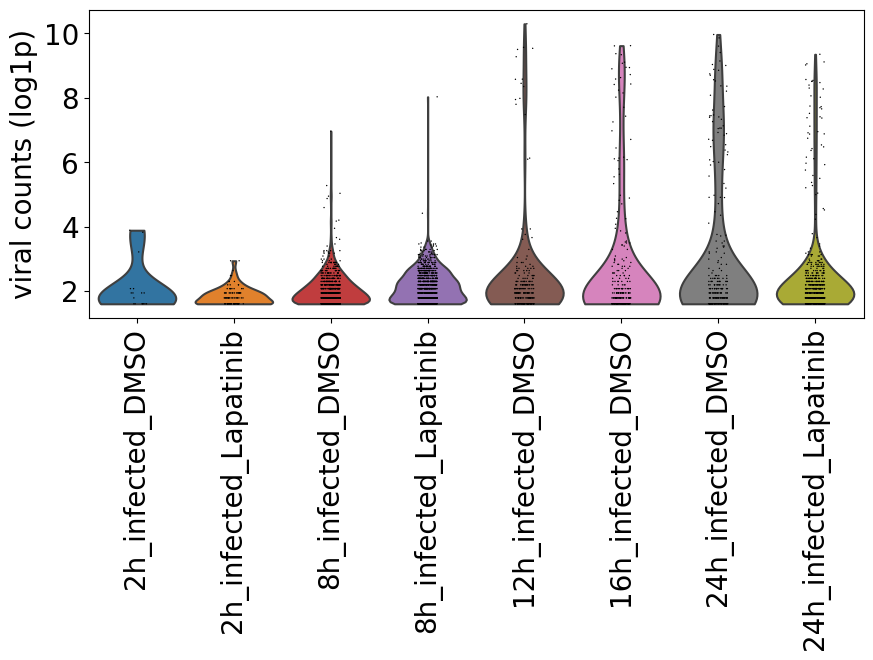

In [23]:
### VHCs only

groupby_order = ['2h_infected_DMSO', '2h_infected_Lapatinib',
                '8h_infected_DMSO', '8h_infected_Lapatinib', 
                '12h_infected_DMSO', '16h_infected_DMSO',
                '24h_infected_DMSO', '24h_infected_Lapatinib',
                ]
ct = 'AT2-like cells'
adata_ct = adata[adata.obs.new_cell_type==ct]
adata_ct.obs['viral counts (log1p)'] = np.log1p(adata_ct.obs['viral_counts'])
fig, ax = plt.subplots(1, 1, figsize=(10,4),)
sc.pl.violin(adata_ct[adata_ct.obs.bystanders == 'high'], keys='viral counts (log1p)', groupby='ID', rotation=90,
    order=groupby_order, ax=ax
            )
plt.show()

In [61]:
adata_id = adata[adata.obs.new_cell_type=='AT2-like cells']
adata_id = adata_id[(adata_id.obs.ID.isin(['24h_infected_DMSO'])) & 
                   (adata_id.obs.bystanders == 'high')].copy()
adata_id.obs['viral_CPM_2'] = adata_id.obs['viral_counts'] * 1000000 / adata_id.obs.total_counts

df1 = sc.get.obs_df(adata_id, keys=adata_id.var_names.to_list())
df2 = adata_id.obs.viral_CPM_2
df = df1.corrwith(df2, method='pearson',)
df = pd.DataFrame(df)
df = pd.concat([df, pd.DataFrame(df1.corrwith(df2, method='spearman',))], axis=1)
df = pd.concat([df, pd.DataFrame(df1.mean())], axis=1)
df.columns = ['pearson','spearman','mean_expression']
df.dropna(axis=1, how='all', inplace=True)
#df.to_csv(f'{save_tables}correlation_24hDMSO_viral_CPM_AT2_VHCs.csv', sep='\t')


df['abs(pearson)'] = abs(df['pearson'])
df['significant'] = 'NS'
df = df[(df.mean_expression > 0.2)]
df_vhcs = df.copy()


In [63]:
df_vhcs[(df_vhcs.mean_expression > 1) & (df_vhcs['abs(pearson)'] > 0.4)]

pearson  spearman  mean_expression  abs(pearson) significant
CTNNA1          -0.485828 -0.305225         6.074900      0.485828          NS
PKM             -0.402460 -0.338876         5.476779      0.402460          NS
DHRS9           -0.462012 -0.228864         6.077801      0.462012          NS
DNM2            -0.401603 -0.270862         4.717565      0.401603          NS
DSP             -0.425362 -0.285766         7.961929      0.425362          NS
PCSK5           -0.449663 -0.176621         4.899634      0.449663          NS
PYGB            -0.474844 -0.250354         5.855609      0.474844          NS
ZMYND8          -0.455660 -0.192035         5.606772      0.455660          NS
ESRP1           -0.405818 -0.188265         4.995408      0.405818          NS
MYH14           -0.408895 -0.253234         5.768731      0.408895          NS
RAI1            -0.406722 -0.376201         4.946868      0.406722          NS
NECTIN1         -0.532539 -0.239989         5.962563      0.532539          NS
PERP            -0.516650 -0.299659         6.213157      0.516650          NS
QSOX1           -0.496927 -0.277831         5.211609      0.496927          NS
SLC2A1          -0.401625 -0.355328         5.425976      0.401625          NS
PPL             -0.429743 -0.301882         6.677495      0.429743          NS
AHNAK           -0.417958 -0.384677         7.331158      0.417958          NS
EPS8L1          -0.452012 -0.250722         6.048049      0.452012          NS
CAP1            -0.422336 -0.266170         5.065897      0.422336          NS
MPRIP           -0.422490 -0.245238         7.009068      0.422490          NS
TMBIM1          -0.435472 -0.406500         5.981012      0.435472          NS
SCEL            -0.534835 -0.286304         7.858457      0.534835          NS
NIBAN2          -0.450833 -0.356995         6.381593      0.450833          NS
TMPRSS4         -0.454525 -0.275132         5.949968      0.454525          NS
FGD4            -0.441464 -0.202193         5.483227      0.441464          NS
RHCG            -0.410393 -0.280467         5.297855      0.410393          NS
MBOAT2          -0.544094 -0.164183         7.588069      0.544094          NS
ZNF185          -0.518915 -0.248927         5.496696      0.518915          NS
FAM83A          -0.485554 -0.300251         5.867995      0.485554          NS
GSN             -0.417283 -0.427663         6.082445      0.417283          NS
PITPNC1         -0.408828 -0.288834         5.645691      0.408828          NS
PCDH1           -0.403946 -0.311084         4.189359      0.403946          NS
WASF2           -0.500939 -0.285095         5.611025      0.500939          NS
NBEAL2          -0.463028 -0.262347         5.900320      0.463028          NS
CAPN2           -0.493205 -0.278292         5.827395      0.493205          NS
AFF1            -0.415400 -0.216730         6.058544      0.415400          NS
ABLIM3          -0.426123 -0.194784         5.028115      0.426123          NS
GOLGB1          -0.439159 -0.294827         5.364699      0.439159          NS
JUP             -0.415275 -0.290294         6.437918      0.415275          NS
ANXA2           -0.431919 -0.364151         7.854112      0.431919          NS
S100A16         -0.420091 -0.298392         5.545656      0.420091          NS
H1-0            -0.417352 -0.337453         4.789618      0.417352          NS
LRBA            -0.554644 -0.107268         6.315487      0.554644          NS
NAALADL2-AS2     0.505763  0.320069         1.363579      0.505763          NS
LINC00511       -0.400214 -0.334425         6.506461      0.400214          NS
ENSG00000229618  0.471740  0.355688         1.680220      0.471740          NS

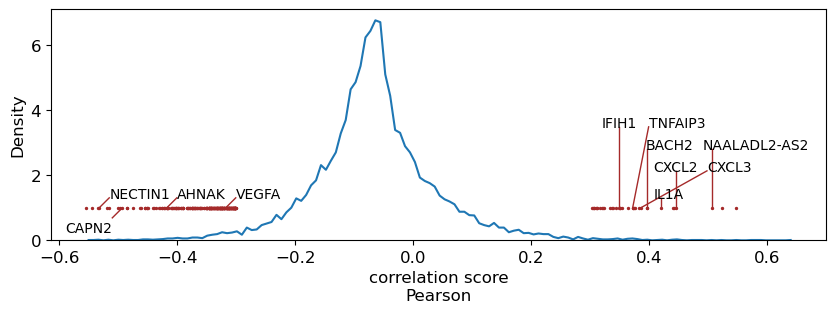

In [67]:
plt.rcParams['font.size']= 12

sasp_genes = ['Tp53', 'Cdkn1a', 'Cdkn2a', 'Cdkn2d', 'AHNAK', 'CAPN2', 'NECTIN1', 'TNFAIP3',
         'Mdm2', 'Ccnd1', 'LMNB1', 'MKI67', 'BGN', 'COL1A1', 'DCN', 'FN1', 'EFEMP1', 'THBS1', 'TIMP1', 'TIMP2', 
         'MMP1', 'MMP2', 'MMP3', 'MMP9', 'SERPINE1', 'CCL2', 'CCL20', 'CXCL12', 'CXCL1', 'CXCL2', 'CXCL3', 'CXCL8', 'CCL9', 
         'IL1A', 'IL1B', 'IL6', 'IL7', 'IL8', 'IL13', 'IL15', 'IFNA1', 'IFNB1', 'IFNG', 'TNF', #'TNF', 
         'EGF', 'FGF2', 'FGF7', 'CSF1', 'GDNF', 'IGFBP2', 'IGFBP6', 'KITLG', 'CTGF', 'VEGFA', 'TGFB1',
        'IFIH1', 'BACH2', 'NAALADL2-AS2']

import textalloc as ta
from adjustText import adjust_text

corr = df_vhcs.copy()
#genes = list(corr[(corr.mean_expression < 0.2)].index)
#corr['significant'][genes] = 'low expression'
genes = [*list(corr[(corr.mean_expression > 0.4) & 
                    (corr['abs(pearson)'] > 0.3)].index), #'ANKRD33B', 'THSD7A', 'NAALADL2-AS2', 'CXCL2', 'IL1A'
        ]
genes = [x for x in genes if 'ENSG00' not in x]
genes = [x for x in genes if 'LINC' not in x]
genes = [x for x in genes if 'MIR' not in x]
corr['significant'][genes] = 'significant'


fig, ax = plt.subplots(figsize=[10, 3])
sns.histplot(
    data=corr, x="pearson", ax=ax,
    element="poly", fill=False,
    stat="density", 
    common_norm=False,
)
genes = list(corr[corr.significant == 'significant'].index)
genes1 = [z for z in genes if z in sasp_genes ]

ax.scatter(corr['pearson'][genes], [1]*len(genes), s=2, marker='o', c='brown')
ta.allocate(ax, corr['pearson'][genes1], [1]*len(genes1), genes1,
            x_scatter=corr['pearson'], y_scatter=corr['mean_expression'], 
            textsize=10, linecolor='brown')


ax.set_xlabel('correlation score\nPearson')
#plt.savefig(save_figures + f'Pearson_corr_vRNA_CPM_24hinfectedDMSO_AT2_all_2.svg')
plt.show()





log2 fold change analysis
- scanpy's rank_genes_groups function
- used as kind of a verification that our in-house calculation returns similar results




In [16]:
ct = 'AT2-like cells'
adata_ct = adata[adata.obs.new_cell_type == ct].copy()
ress = {}

labels = {'2h_infected_DMSO': ['bystanders', 'high', 'zero'],
          '8h_infected_DMSO': ['bystanders', 'high', 'zero'],
          '12h_infected_DMSO': ['bystanders', 'high', 'zero'],
          '16h_infected_DMSO': ['bystanders', 'high', 'zero'],
          '24h_infected_DMSO': ['bystanders', 'high', 'zero'],
          '2h_VHCs': ['treated', 'Lapatinib', 'DMSO'],
          '8h_VHCs': ['treated', 'Lapatinib', 'DMSO'],
          '24h_VHCs': ['treated', 'Lapatinib', 'DMSO'],
          '2h_infected_DMSO-2h_uninfected_DMSO': ['ID','2h_infected_DMSO', '2h_uninfected_DMSO'], 
          '2h_infected_Lapatinib-2h_infected_DMSO': ['ID', '2h_infected_Lapatinib', '2h_infected_DMSO'],
          '24h_infected_DMSO-24h uninfected DMSO': ['ID','24h_infected_DMSO', '24h uninfected DMSO'],
          '24h_infected_Lapatinib-24h_infected_DMSO': ['ID', '24h_infected_Lapatinib', '24h_infected_DMSO'],
         }

for label, value in labels.items():
    groupby = value[0]
    groups = value[1:]
    reference = value[2]
    if 'VHCs' in label: 
        ids = [label.split('_')[0]+'_infected_DMSO', label.split('_')[0]+'_infected_Lapatinib']
        adata_id = adata_ct[(adata_ct.obs.ID.isin(ids)) &
                           (adata_ct.obs.bystanders.isin(['high']))].copy()
    else: 
        ids = label.split('-')
        adata_id = adata_ct[adata_ct.obs.ID.isin(ids)].copy()
    
    sc.tl.rank_genes_groups(adata_id, groupby, method='wilcoxon', key_added = "wilcoxon",
                            groups = groups, reference = reference, )
    ress[label] = adata_id.uns['wilcoxon']

markers = pd.DataFrame([])
for s,results in ress.items():
    out = np.array([[0,0,0,0,0,0,0,0]])
    for group in results['names'].dtype.names:
        out = np.vstack((out, np.vstack((results['names'][group],
                                     results['scores'][group],
                                     results['pvals_adj'][group],
                                     results['pvals'][group],
                                     results['logfoldchanges'][group],
                                     np.array([s] * len(results['names'][group]),).astype('object'),
                                     np.array([results['params']['reference']] * len(results['names'][group]),).astype('object'),
                                     #np.array([group] * len(results['names'][group]),).astype('object'),
                                     np.array([ct] * len(results['names'][group]),).astype('object'),
                                    )).T
                        ))
    out = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'pval', 'lfc', 'Condition', 'reference', 'cell_type'])
    markers = pd.concat([markers, out], axis=0, join='outer')


df = markers.pivot_table(index='Gene', columns='Condition', values='lfc')
df2 = markers.pivot_table(index='Gene', columns='Condition', values='pval')


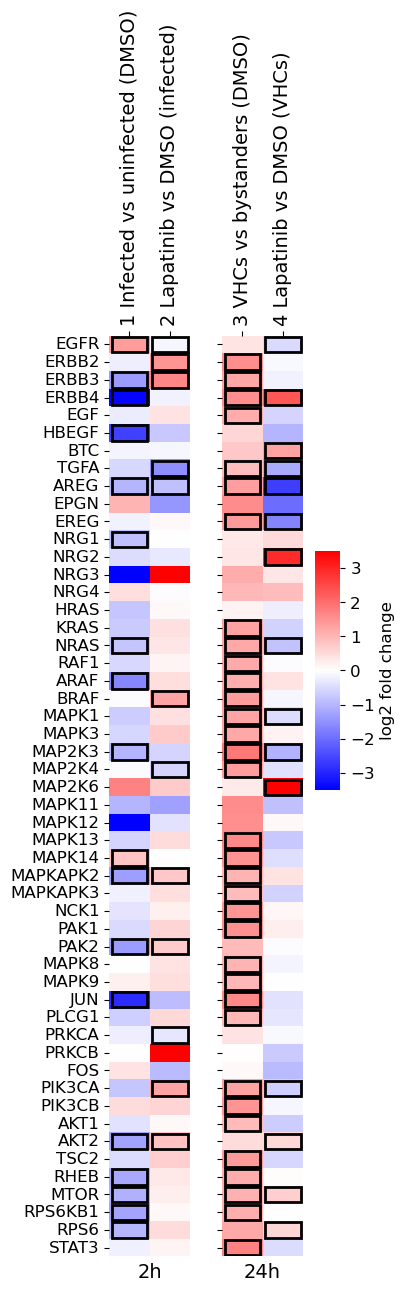

In [129]:
genes = ['EGFR', 'ERBB2', 'ERBB3', 'ERBB4', 'EGF', 'HBEGF', 'BTC', 'TGFA', 'AREG', 'EPGN', 'EREG',     
                       'NRG1', 'NRG2', 'NRG3', 'NRG4', 
        'HRAS', 'KRAS', 'NRAS', 'RAF1', 'ARAF', 'BRAF', 'MAPK1', 'MAPK3', 
         'MAP2K3', 'MAP2K4', 'MAP2K6', 'MAPK11', 'MAPK12', 'MAPK13', 'MAPK14', 'MAPKAPK2', 'MAPKAPK3',
                       'NCK1', 'PAK1', 'PAK2', 'MAPK8', 'MAPK9', 'JUN', 'PLCG1', 'PRKCA', 'PRKCB', 'AP1', 
         'FOS', 'PIK3CA', 'PIK3CB', 'AKT1', 'AKT2', 'TSC2', 'RHEB', 'MTOR', 'RPS6KB1', 'RPS6', 
         'JAK', 'STAT3',
         ]
genes = [x for x in genes if x in adata.var_names]

title = ''
labels = ['2h_infected_DMSO-2h_uninfected_DMSO',
          '2h_infected_Lapatinib-2h_infected_DMSO',
          '24h_infected_DMSO', '24h_VHCs']

fig, axs = plt.subplots(1, 2, sharey=True, 
                        figsize=(2.5, len(genes)*0.23,), 
                        gridspec_kw={'wspace':0.4})
cbar_ax = fig.add_axes([.95, .5, .1, .2])


l = labels[:2]
tmp = df.loc[genes][l]
sns.heatmap(tmp, cmap='bwr', vmin=-3.5, vmax=3.5, ax=axs[0], 
            cbar=True, cbar_ax=cbar_ax, cbar_kws={'label': 'log2 fold change'})
pval = df2.loc[genes][l]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            axs[0].add_patch(
                mpl.patches.Rectangle(
                     (i+0.07, j+0.07),0.87, 0.87,
                    edgecolor='black',fill=False,lw=2
                ) )


axs[0].set_xticklabels(['1 Infected vs uninfected (DMSO)', '2 Lapatinib vs DMSO (infected)',],
                       fontsize=14, rotation=90)
axs[0].xaxis.tick_top()
axs[0].set_title('')
axs[0].set_xlabel('2h', fontsize=14,)
axs[0].set_ylabel('')


l = labels[2:]
tmp = df[l].loc[genes]
sns.heatmap(tmp, cmap='bwr', vmin=-3.5, vmax=3.5, ax=axs[1], 
            cbar=True, cbar_ax=cbar_ax, cbar_kws={'label': 'log2 fold change'})
pval = df2.loc[genes][l]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            axs[1].add_patch(
                mpl.patches.Rectangle(
                     (i+0.07, j+0.07),0.87, 0.87,
                    edgecolor='black',fill=False,lw=2
                ) )
axs[1].set_xticklabels(['3 VHCs vs bystanders (DMSO)', 
                     '4 Lapatinib vs DMSO (VHCs)',],
                       fontsize=14, rotation=90)
axs[1].xaxis.tick_top()
axs[1].set_title('')
axs[1].set_xlabel('24h', fontsize=14,)
axs[1].set_ylabel('')


fig.tight_layout()
#fig.savefig(figure_path+'heatmap_autophagy_genes_4h_linewidth1_3_new_updated.svg', format="svg")
plt.show()


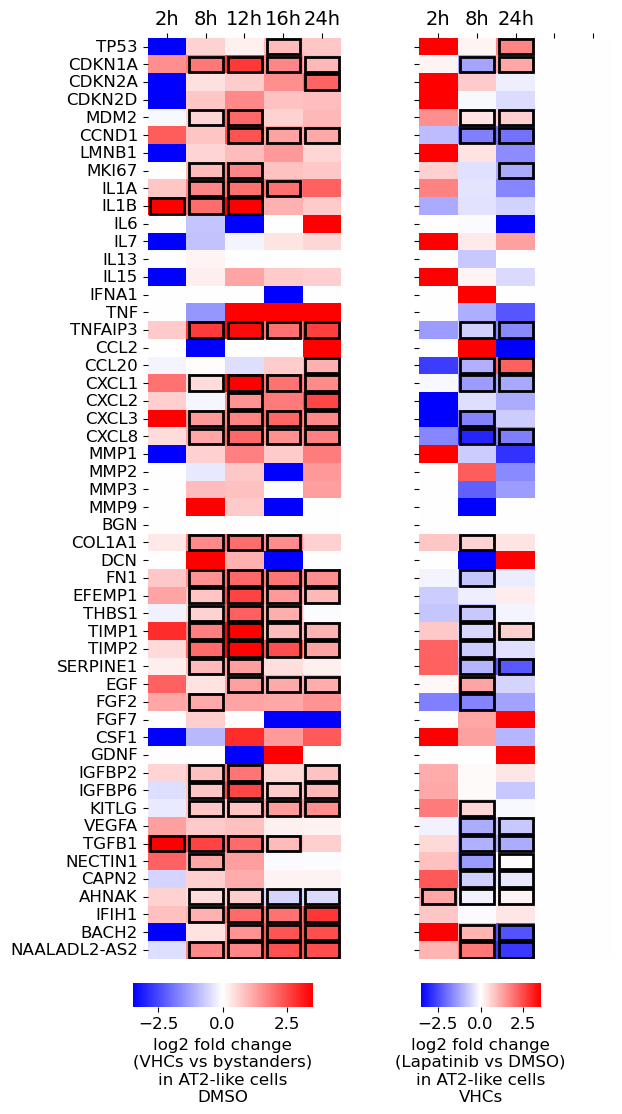

In [133]:
title = ''
genes = ['Tp53', 'Cdkn1a', 'Cdkn2a', 'Cdkn2d', 'Mdm2', 'Ccnd1', 'LMNB1', 'MKI67', 'IL1A', 'IL1B', 'IL6', 'IL7', 'IL13', 'IL15', 'IFNA1', 'IFNB1', 'IFNG', 'TNF', 'TNFAIP3', 'CCL2', 'CCL9', 'CCL20', 'CXCL1', 'CXCL2', 'CXCL3', 'CXCL8', 'MMP1', 'MMP2', 'MMP3', 'MMP9', 'BGN', 'COL1A1', 'DCN', 'FN1', 'EFEMP1', 'THBS1', 'TIMP1', 'TIMP2', 'SERPINE1', 'EGF', 'FGF2', 'FGF7', 'CSF1', 'GDNF', 'IGFBP2', 'IGFBP6', 'KITLG', 'CTGF', 'VEGFA', 'TGFB1', 'NECTIN1', 'CAPN2', 'AHNAK', 'IFIH1', 'BACH2', 'NAALADL2-AS2']
genes = [x.upper() for x in genes if x.upper() in adata.var_names]
fig, axs = plt.subplots(1, 2, sharey=True, 
                        figsize=(6, len(genes)*0.23,), 
                        gridspec_kw={'wspace':0.4})


cbar_ax1 = fig.add_axes([.15, .07, .2, .02])
labels = ['2h_infected_DMSO', '8h_infected_DMSO', '12h_infected_DMSO', '16h_infected_DMSO', '24h_infected_DMSO']
tmp = df.loc[genes][labels]
sns.heatmap(tmp, cmap='bwr', vmin=-3.5, vmax=3.5, ax=axs[0], 
            cbar=True, cbar_ax=cbar_ax1, 
            cbar_kws={'label': 'log2 fold change\n(VHCs vs bystanders)\nin AT2-like cells\nDMSO',
                     'orientation': 'horizontal'})
pval = df2.loc[genes][labels]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            axs[0].add_patch(
                mpl.patches.Rectangle(
                     (i+0.07, j+0.07),0.87, 0.87,
                    edgecolor='black',fill=False,lw=2
                ) )
axs[0].set_xticklabels(['2h', '8h', '12h', '16h', '24h',],fontsize=14)
axs[0].xaxis.tick_top()
axs[0].set_title('')
axs[0].set_ylabel('')
axs[0].set_xlabel('')


cbar_ax2 = fig.add_axes([.58, .07, .2, .02])
df['z1']=0
df['z2']=0
df2['z1']=1
df2['z2']=1
labels = ['2h_VHCs', '8h_VHCs', '24h_VHCs', 'z1','z2']
tmp = df.loc[genes][labels]
sns.heatmap(tmp, cmap='bwr', vmin=-3.5, vmax=3.5, ax=axs[1], 
            cbar=True, cbar_ax=cbar_ax2, 
            cbar_kws={'label': 'log2 fold change\n(Lapatinib vs DMSO)\nin AT2-like cells\nVHCs',
                     'orientation': 'horizontal'})
pval = df2.loc[genes][labels]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            axs[1].add_patch(
                mpl.patches.Rectangle(
                     (i+0.07, j+0.07),0.87, 0.87,
                    edgecolor='black',fill=False,lw=2
                ) )

axs[1].set_xticklabels(['2h', '8h', '24h', '', ''],fontsize=14)
axs[1].xaxis.tick_top()
axs[1].set_title('')
axs[1].set_ylabel('')
axs[1].set_xlabel('')


fig.tight_layout()
#fig.savefig(figure_path+'heatmap_autophagy_genes_4h_linewidth1_3_new_updated.svg', format="svg")
plt.show()






log2 fold change analysis
- in-house calculation
- random selection of equal number of bystanders and VHCs (iterated 100x)





In [17]:
### alternative calculation under
# Compute log2 fold changes
def sample_and_compare(adata1, adata2, n_sample=0, n=100, pseudocount=False):
    from random import sample
    if n_sample == 0: n_sample = min(adata1.shape[0], adata2.shape[0])
    var_names = [x for x in adata1.var_names if x in adata2.var_names]
    results = pd.DataFrame(np.zeros((n, len(var_names)), np.float64),
                           columns=var_names,)
    for x in np.arange(n):
        samplelist1 = sample(list(adata1.obs_names), n_sample)
        samplelist2 = sample(list(adata2.obs_names), n_sample)
        
        adata_1 = adata1[np.in1d(adata1.obs.index, samplelist1),:]
        adata_2 = adata2[np.in1d(adata2.obs.index, samplelist2),:]
        
        # Compute averages
        avg1 = adata_1.X.mean(axis=0)
        avg2 = adata_2.X.mean(axis=0)
        
        # Compute log2 fold changes
        if pseudocount: log2_fc = np.log2((np.expm1(avg1 * np.log(2)) + pseudocount) /(np.expm1(avg2 * np.log(2)) + pseudocount))
        else: log2_fc = avg1 - avg2
        
        results.loc[x] = log2_fc
    return results



In [18]:
ct = 'AT2-like cells'
adata_ct = adata[adata.obs.new_cell_type == ct].copy()
ress = {}

labels = {'2h_infected_DMSO': ['bystanders', 'high', 'zero'],
          '8h_infected_DMSO': ['bystanders', 'high', 'zero'],
          '12h_infected_DMSO': ['bystanders', 'high', 'zero'],
          '16h_infected_DMSO': ['bystanders', 'high', 'zero'],
          '24h_infected_DMSO': ['bystanders', 'high', 'zero'],
          '2h_VHCs': ['treated', 'Lapatinib', 'DMSO'],
          '8h_VHCs': ['treated', 'Lapatinib', 'DMSO'],
          '24h_VHCs': ['treated', 'Lapatinib', 'DMSO'],
          '2h_infected_DMSO-2h_uninfected_DMSO': ['ID','2h_infected_DMSO', '2h_uninfected_DMSO'], 
          '2h_infected_Lapatinib-2h_infected_DMSO': ['ID', '2h_infected_Lapatinib', '2h_infected_DMSO'],
          '24h_infected_DMSO-24h uninfected DMSO': ['ID','24h_infected_DMSO', '24h uninfected DMSO'],
          '24h_infected_Lapatinib-24h_infected_DMSO': ['ID', '24h_infected_Lapatinib', '24h_infected_DMSO'],
         }
pseudocount = False
log2fcs = pd.DataFrame()
for label, value in labels.items():
    groupby = value[0]
    groups = value[1:]
    reference = value[2]
    if groupby == 'bystanders': 
        ids = label.split('-')
        adata_id = adata_ct[adata_ct.obs.ID.isin(ids)].copy()
        adata1 = adata_id[adata_id.obs[groupby] == groups[0]]
        adata2 = adata_id[adata_id.obs[groupby] == groups[1]]
        if adata1.shape[0]<3: continue
        if adata2.shape[0]<3: continue
        df1 = sample_and_compare(adata1, adata2, n_sample=0, 
                            n=100, pseudocount=pseudocount)
        df1 = pd.DataFrame(df1.median(), columns=[label])
        log2fcs = pd.concat([log2fcs, df1], axis=1)
    
    else:
        if 'VHCs' in label: 
            ids = [label.split('_')[0]+'_infected_Lapatinib', label.split('_')[0]+'_infected_DMSO']
            adata_id = adata_ct[(adata_ct.obs.ID.isin(ids)) &
                           (adata_ct.obs.bystanders.isin(['high']))].copy()
        else:
            ids = label.split('-')
            adata_id = adata_ct[adata_ct.obs.ID.isin(ids)].copy()
        adata1 = adata_id[adata_id.obs.ID == ids[0]]
        adata2 = adata_id[adata_id.obs.ID == ids[1]]
        avg1 = adata1.X.mean(axis=0)
        avg2 = adata2.X.mean(axis=0)
        # Compute log2 fold changes
        if pseudocount: df1 = np.log2((np.expm1(avg1 * np.log(2)) + pseudocount) /(np.expm1(avg2 * np.log(2)) + pseudocount))
        else: df1 = avg1 - avg2
        df1 = pd.DataFrame(df1).T
        df1.index = adata_id.var_names
        df1.columns = [label]
        log2fcs = pd.concat([log2fcs, df1], axis=1)


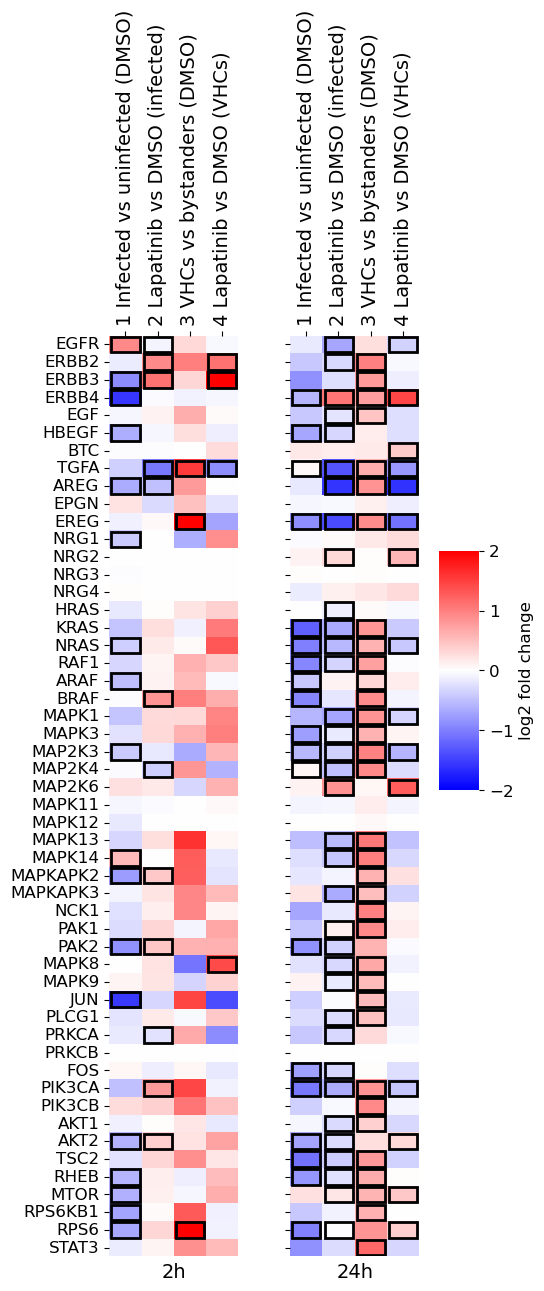

In [22]:
plt.rcParams['font.size']= 12
genes = ['EGFR', 'ERBB2', 'ERBB3', 'ERBB4', 'EGF', 'HBEGF', 'BTC', 'TGFA', 'AREG', 'EPGN', 'EREG',     
                       'NRG1', 'NRG2', 'NRG3', 'NRG4', 
        'HRAS', 'KRAS', 'NRAS', 'RAF1', 'ARAF', 'BRAF', 'MAPK1', 'MAPK3', 
         'MAP2K3', 'MAP2K4', 'MAP2K6', 'MAPK11', 'MAPK12', 'MAPK13', 'MAPK14', 'MAPKAPK2', 'MAPKAPK3',
                       'NCK1', 'PAK1', 'PAK2', 'MAPK8', 'MAPK9', 'JUN', 'PLCG1', 'PRKCA', 'PRKCB', 'AP1', 
         'FOS', 'PIK3CA', 'PIK3CB', 'AKT1', 'AKT2', 'TSC2', 'RHEB', 'MTOR', 'RPS6KB1', 'RPS6', 
         'JAK', 'STAT3',
         ]
genes = [x for x in genes if x in adata.var_names]

title = ''
labels = ['2h_infected_DMSO-2h_uninfected_DMSO',
          '2h_infected_Lapatinib-2h_infected_DMSO',
          '2h_infected_DMSO', '2h_VHCs',
          '24h_infected_DMSO-24h uninfected DMSO',
          '24h_infected_Lapatinib-24h_infected_DMSO',
          '24h_infected_DMSO', '24h_VHCs']

fig, axs = plt.subplots(1, 2, sharey=True, 
                        figsize=(4, len(genes)*0.23,), 
                        gridspec_kw={'wspace':0.4})
cbar_ax = fig.add_axes([.95, .5, .1, .2])


l = labels[:4]
tmp = log2fcs.loc[genes][l]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=axs[0], 
            cbar=True, cbar_ax=cbar_ax, cbar_kws={'label': 'log2 fold change'})
pval = df2.loc[genes][l]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            axs[0].add_patch(
                mpl.patches.Rectangle(
                     (i+0.07, j+0.07),0.87, 0.87,
                    edgecolor='black',fill=False,lw=2
                ) )


axs[0].set_xticklabels(['1 Infected vs uninfected (DMSO)', '2 Lapatinib vs DMSO (infected)',
                       '3 VHCs vs bystanders (DMSO)', '4 Lapatinib vs DMSO (VHCs)',],
                       fontsize=14, rotation=90)
axs[0].xaxis.tick_top()
axs[0].set_title('')
axs[0].set_xlabel('2h', fontsize=14,)
axs[0].set_ylabel('')


l = labels[4:]
tmp = log2fcs[l].loc[genes]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=axs[1], 
            cbar=True, cbar_ax=cbar_ax, cbar_kws={'label': 'log2 fold change'})
pval = df2.loc[genes][l]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            axs[1].add_patch(
                mpl.patches.Rectangle(
                     (i+0.07, j+0.07),0.87, 0.87,
                    edgecolor='black',fill=False,lw=2
                ) )
axs[1].set_xticklabels(['1 Infected vs uninfected (DMSO)', '2 Lapatinib vs DMSO (infected)',
                       '3 VHCs vs bystanders (DMSO)', '4 Lapatinib vs DMSO (VHCs)',],
                       fontsize=14, rotation=90)
axs[1].xaxis.tick_top()
axs[1].set_title('')
axs[1].set_xlabel('24h', fontsize=14,)
axs[1].set_ylabel('')


fig.tight_layout()
#fig.savefig(figure_path+'heatmap_autophagy_genes_4h_linewidth1_3_new_updated.svg', format="svg")
plt.show()


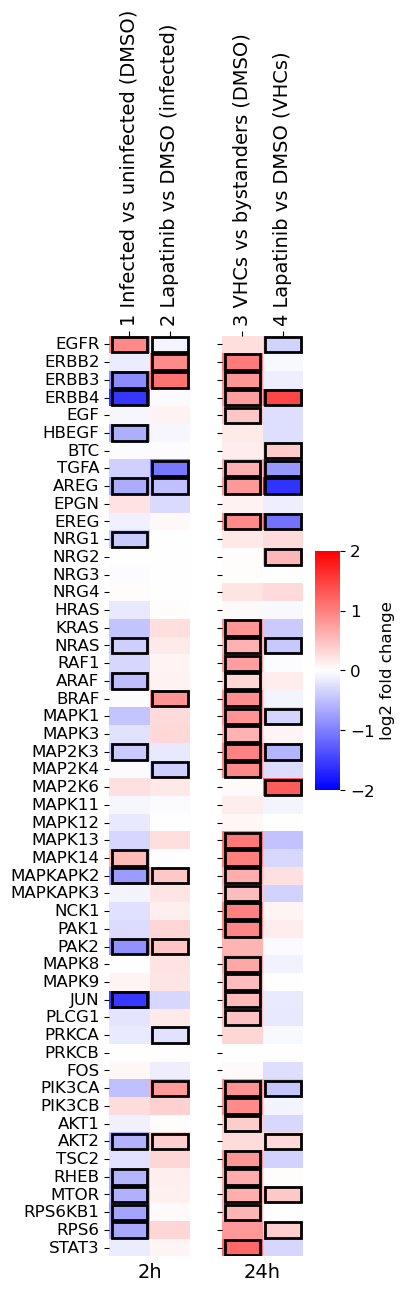

In [201]:
plt.rcParams['font.size']= 12
genes = ['EGFR', 'ERBB2', 'ERBB3', 'ERBB4', 'EGF', 'HBEGF', 'BTC', 'TGFA', 'AREG', 'EPGN', 'EREG',     
                       'NRG1', 'NRG2', 'NRG3', 'NRG4', 
        'HRAS', 'KRAS', 'NRAS', 'RAF1', 'ARAF', 'BRAF', 'MAPK1', 'MAPK3', 
         'MAP2K3', 'MAP2K4', 'MAP2K6', 'MAPK11', 'MAPK12', 'MAPK13', 'MAPK14', 'MAPKAPK2', 'MAPKAPK3',
                       'NCK1', 'PAK1', 'PAK2', 'MAPK8', 'MAPK9', 'JUN', 'PLCG1', 'PRKCA', 'PRKCB', 'AP1', 
         'FOS', 'PIK3CA', 'PIK3CB', 'AKT1', 'AKT2', 'TSC2', 'RHEB', 'MTOR', 'RPS6KB1', 'RPS6', 
         'JAK', 'STAT3',
         ]
genes = [x for x in genes if x in adata.var_names]

title = ''
labels = ['2h_infected_DMSO-2h_uninfected_DMSO',
          '2h_infected_Lapatinib-2h_infected_DMSO',
          '24h_infected_DMSO', '24h_VHCs']

fig, axs = plt.subplots(1, 2, sharey=True, 
                        figsize=(2.5, len(genes)*0.23,), 
                        gridspec_kw={'wspace':0.4})
cbar_ax = fig.add_axes([.95, .5, .1, .2])


l = labels[:2]
tmp = log2fcs.loc[genes][l]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=axs[0], 
            cbar=True, cbar_ax=cbar_ax, cbar_kws={'label': 'log2 fold change'})
pval = df2.loc[genes][l]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            axs[0].add_patch(
                mpl.patches.Rectangle(
                     (i+0.07, j+0.07),0.87, 0.87,
                    edgecolor='black',fill=False,lw=2
                ) )


axs[0].set_xticklabels(['1 Infected vs uninfected (DMSO)', '2 Lapatinib vs DMSO (infected)',],
                       fontsize=14, rotation=90)
axs[0].xaxis.tick_top()
axs[0].set_title('')
axs[0].set_xlabel('2h', fontsize=14,)
axs[0].set_ylabel('')


l = labels[2:]
tmp = log2fcs[l].loc[genes]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=axs[1], 
            cbar=True, cbar_ax=cbar_ax, cbar_kws={'label': 'log2 fold change'})
pval = df2.loc[genes][l]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            axs[1].add_patch(
                mpl.patches.Rectangle(
                     (i+0.07, j+0.07),0.87, 0.87,
                    edgecolor='black',fill=False,lw=2
                ) )
axs[1].set_xticklabels(['3 VHCs vs bystanders (DMSO)', 
                     '4 Lapatinib vs DMSO (VHCs)',],
                       fontsize=14, rotation=90)
axs[1].xaxis.tick_top()
axs[1].set_title('')
axs[1].set_xlabel('24h', fontsize=14,)
axs[1].set_ylabel('')


fig.tight_layout()
#fig.savefig(figure_path+'heatmap_autophagy_genes_4h_linewidth1_3_new_updated.svg', format="svg")
plt.show()


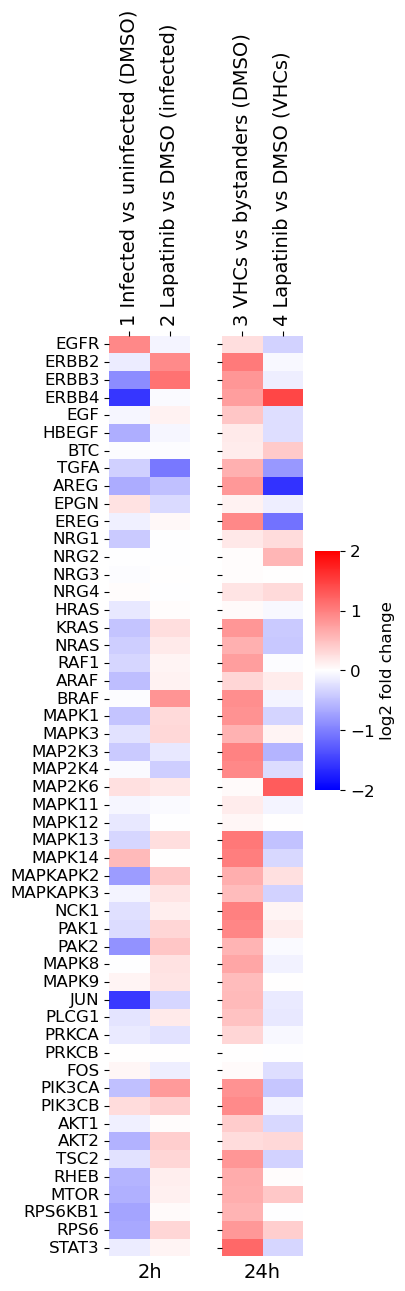

In [202]:
genes = ['EGFR', 'ERBB2', 'ERBB3', 'ERBB4', 'EGF', 'HBEGF', 'BTC', 'TGFA', 'AREG', 'EPGN', 'EREG',     
                       'NRG1', 'NRG2', 'NRG3', 'NRG4', 
        'HRAS', 'KRAS', 'NRAS', 'RAF1', 'ARAF', 'BRAF', 'MAPK1', 'MAPK3', 
         'MAP2K3', 'MAP2K4', 'MAP2K6', 'MAPK11', 'MAPK12', 'MAPK13', 'MAPK14', 'MAPKAPK2', 'MAPKAPK3',
                       'NCK1', 'PAK1', 'PAK2', 'MAPK8', 'MAPK9', 'JUN', 'PLCG1', 'PRKCA', 'PRKCB', 'AP1', 
         'FOS', 'PIK3CA', 'PIK3CB', 'AKT1', 'AKT2', 'TSC2', 'RHEB', 'MTOR', 'RPS6KB1', 'RPS6', 
         'JAK', 'STAT3',
         ]
genes = [x for x in genes if x in adata.var_names]

title = ''
labels = ['2h_infected_DMSO-2h_uninfected_DMSO',
          '2h_infected_Lapatinib-2h_infected_DMSO',
          '24h_infected_DMSO', '24h_VHCs']

fig, axs = plt.subplots(1, 2, sharey=True, 
                        figsize=(2.5, len(genes)*0.23,), 
                        gridspec_kw={'wspace':0.4})
cbar_ax = fig.add_axes([.95, .5, .1, .2])


l = labels[:2]
tmp = log2fcs.loc[genes][l]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=axs[0], 
            cbar=True, cbar_ax=cbar_ax, cbar_kws={'label': 'log2 fold change'})
axs[0].set_xticklabels(['1 Infected vs uninfected (DMSO)', '2 Lapatinib vs DMSO (infected)',],
                       fontsize=14, rotation=90)
axs[0].xaxis.tick_top()
axs[0].set_title('')
axs[0].set_xlabel('2h', fontsize=14,)
axs[0].set_ylabel('')


l = labels[2:]
tmp = log2fcs[l].loc[genes]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=axs[1], 
            cbar=True, cbar_ax=cbar_ax, cbar_kws={'label': 'log2 fold change'})
axs[1].set_xticklabels(['3 VHCs vs bystanders (DMSO)', 
                     '4 Lapatinib vs DMSO (VHCs)',],
                       fontsize=14, rotation=90)
axs[1].xaxis.tick_top()
axs[1].set_title('')
axs[1].set_xlabel('24h', fontsize=14,)
axs[1].set_ylabel('')


fig.tight_layout()
#fig.savefig(figure_path+'heatmap_autophagy_genes_4h_linewidth1_3_new_updated.svg', format="svg")
plt.show()


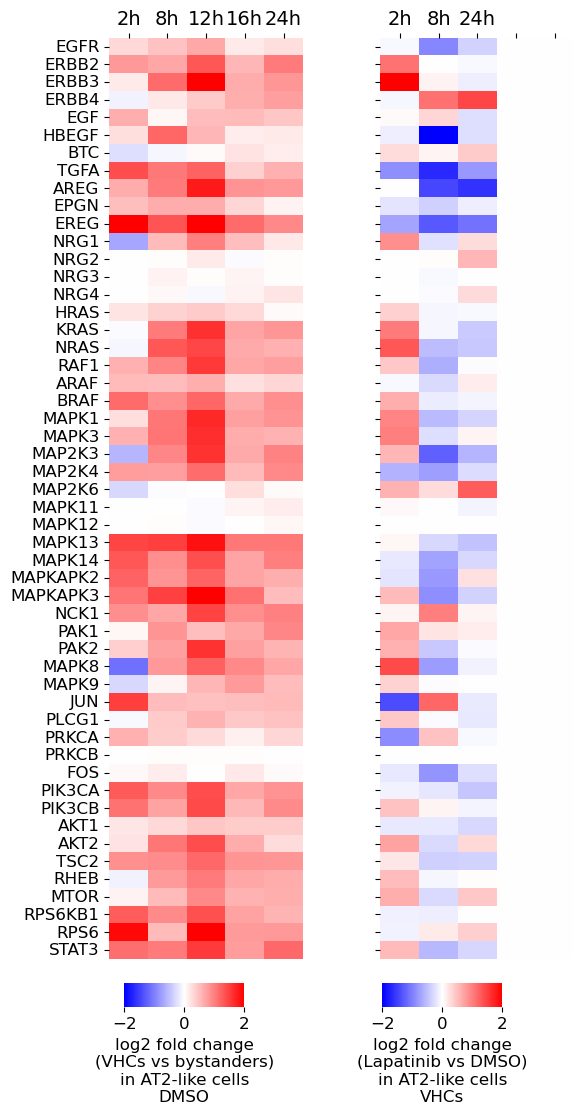

In [256]:
title = ''
fig, axs = plt.subplots(1, 2, sharey=True, 
                        figsize=(6, len(genes)*0.23,), 
                        gridspec_kw={'wspace':0.4})


cbar_ax1 = fig.add_axes([.15, .07, .2, .02])
labels = ['2h_infected_DMSO', '8h_infected_DMSO', '12h_infected_DMSO', '16h_infected_DMSO', '24h_infected_DMSO']
tmp = log2fcs.loc[genes][labels]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=axs[0], 
            cbar=True, cbar_ax=cbar_ax1, 
            cbar_kws={'label': 'log2 fold change\n(VHCs vs bystanders)\nin AT2-like cells\nDMSO',
                     'orientation': 'horizontal'})
axs[0].set_xticklabels(['2h', '8h', '12h', '16h', '24h',],fontsize=14)
axs[0].xaxis.tick_top()
axs[0].set_title('')
axs[0].set_ylabel('')
axs[0].set_xlabel('')


cbar_ax2 = fig.add_axes([.58, .07, .2, .02])
log2fcs['z1']=0
log2fcs['z2']=0
df2['z1']=1
df2['z2']=1
labels = ['2h_VHCs', '8h_VHCs', '24h_VHCs', 'z1','z2']
tmp = log2fcs.loc[genes][labels]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=axs[1], 
            cbar=True, cbar_ax=cbar_ax2, 
            cbar_kws={'label': 'log2 fold change\n(Lapatinib vs DMSO)\nin AT2-like cells\nVHCs',
                     'orientation': 'horizontal'})
axs[1].set_xticklabels(['2h', '8h', '24h', '', ''],fontsize=14)
axs[1].xaxis.tick_top()
axs[1].set_title('')
axs[1].set_ylabel('')
axs[1].set_xlabel('')


fig.tight_layout()
#fig.savefig(figure_path+'heatmap_autophagy_genes_4h_linewidth1_3_new_updated.svg', format="svg")
plt.show()



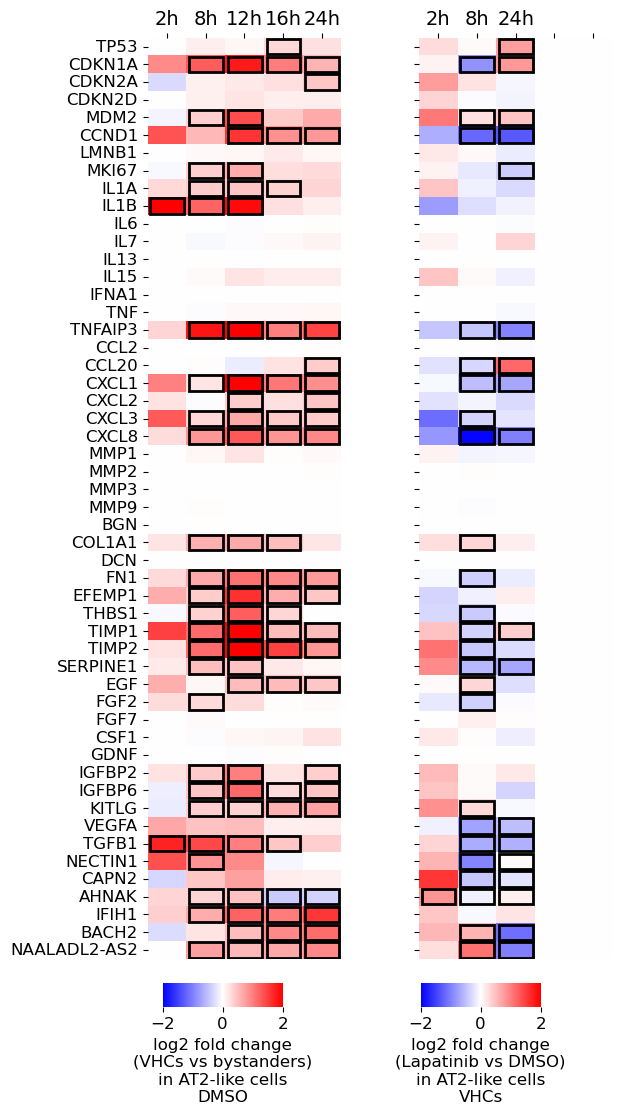

In [203]:
title = ''
genes = ['Tp53', 'Cdkn1a', 'Cdkn2a', 'Cdkn2d', 'Mdm2', 'Ccnd1', 'LMNB1', 'MKI67', 'IL1A', 'IL1B', 'IL6', 'IL7', 'IL13', 'IL15', 'IFNA1', 'IFNB1', 'IFNG', 'TNF', 'TNFAIP3', 'CCL2', 'CCL9', 'CCL20', 'CXCL1', 'CXCL2', 'CXCL3', 'CXCL8', 'MMP1', 'MMP2', 'MMP3', 'MMP9', 'BGN', 'COL1A1', 'DCN', 'FN1', 'EFEMP1', 'THBS1', 'TIMP1', 'TIMP2', 'SERPINE1', 'EGF', 'FGF2', 'FGF7', 'CSF1', 'GDNF', 'IGFBP2', 'IGFBP6', 'KITLG', 'CTGF', 'VEGFA', 'TGFB1', 'NECTIN1', 'CAPN2', 'AHNAK', 'IFIH1', 'BACH2', 'NAALADL2-AS2']
genes = [x.upper() for x in genes if x.upper() in adata.var_names]
fig, axs = plt.subplots(1, 2, sharey=True, 
                        figsize=(6, len(genes)*0.23,), 
                        gridspec_kw={'wspace':0.4})


cbar_ax1 = fig.add_axes([.15, .07, .2, .02])
labels = ['2h_infected_DMSO', '8h_infected_DMSO', '12h_infected_DMSO', '16h_infected_DMSO', '24h_infected_DMSO']
tmp = log2fcs.loc[genes][labels]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=axs[0], 
            cbar=True, cbar_ax=cbar_ax1, 
            cbar_kws={'label': 'log2 fold change\n(VHCs vs bystanders)\nin AT2-like cells\nDMSO',
                     'orientation': 'horizontal'})
pval = df2.loc[genes][labels]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            axs[0].add_patch(
                mpl.patches.Rectangle(
                     (i+0.07, j+0.07),0.87, 0.87,
                    edgecolor='black',fill=False,lw=2
                ) )
axs[0].set_xticklabels(['2h', '8h', '12h', '16h', '24h',],fontsize=14)
axs[0].xaxis.tick_top()
axs[0].set_title('')
axs[0].set_ylabel('')
axs[0].set_xlabel('')


cbar_ax2 = fig.add_axes([.58, .07, .2, .02])
log2fcs['z1']=0
log2fcs['z2']=0
df2['z1']=1
df2['z2']=1
labels = ['2h_VHCs', '8h_VHCs', '24h_VHCs', 'z1','z2']
tmp = log2fcs.loc[genes][labels]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=axs[1], 
            cbar=True, cbar_ax=cbar_ax2, 
            cbar_kws={'label': 'log2 fold change\n(Lapatinib vs DMSO)\nin AT2-like cells\nVHCs',
                     'orientation': 'horizontal'})
pval = df2.loc[genes][labels]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            axs[1].add_patch(
                mpl.patches.Rectangle(
                     (i+0.07, j+0.07),0.87, 0.87,
                    edgecolor='black',fill=False,lw=2
                ) )

axs[1].set_xticklabels(['2h', '8h', '24h', '', ''],fontsize=14)
axs[1].xaxis.tick_top()
axs[1].set_title('')
axs[1].set_ylabel('')
axs[1].set_xlabel('')


fig.tight_layout()
#fig.savefig(figure_path+'heatmap_autophagy_genes_4h_linewidth1_3_new_updated.svg', format="svg")
plt.show()




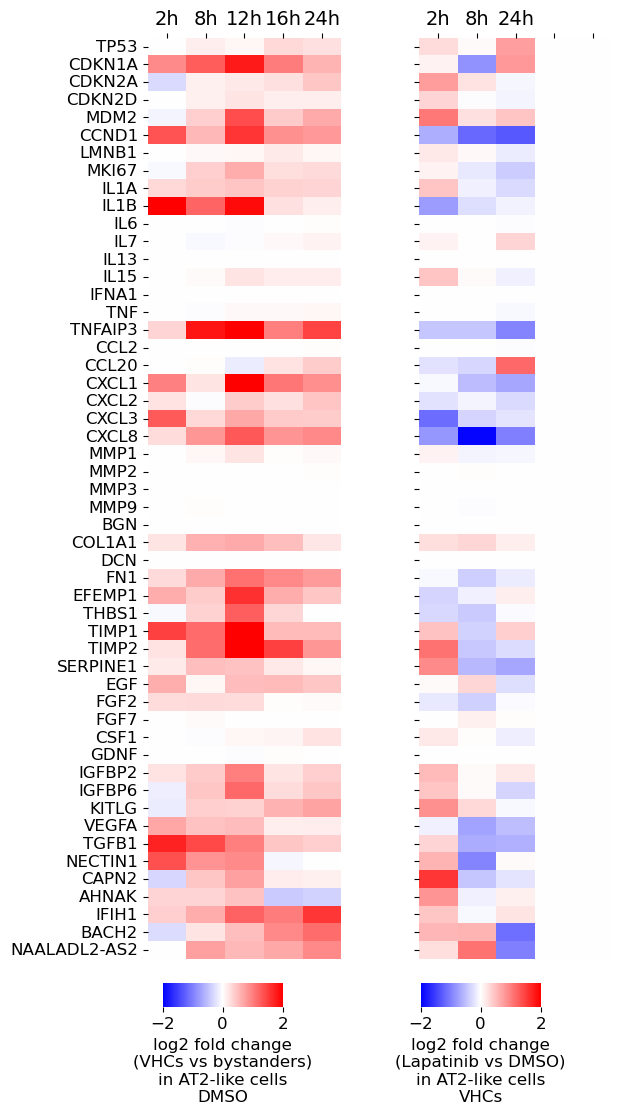

In [204]:
title = ''
genes = ['Tp53', 'Cdkn1a', 'Cdkn2a', 'Cdkn2d', 'Mdm2', 'Ccnd1', 'LMNB1', 'MKI67', 'IL1A', 'IL1B', 'IL6', 'IL7', 'IL13', 'IL15', 'IFNA1', 'IFNB1', 'IFNG', 'TNF', 'TNFAIP3', 'CCL2', 'CCL9', 'CCL20', 'CXCL1', 'CXCL2', 'CXCL3', 'CXCL8', 'MMP1', 'MMP2', 'MMP3', 'MMP9', 'BGN', 'COL1A1', 'DCN', 'FN1', 'EFEMP1', 'THBS1', 'TIMP1', 'TIMP2', 'SERPINE1', 'EGF', 'FGF2', 'FGF7', 'CSF1', 'GDNF', 'IGFBP2', 'IGFBP6', 'KITLG', 'CTGF', 'VEGFA', 'TGFB1', 'NECTIN1', 'CAPN2', 'AHNAK', 'IFIH1', 'BACH2', 'NAALADL2-AS2']
genes = [x.upper() for x in genes if x.upper() in adata.var_names]
fig, axs = plt.subplots(1, 2, sharey=True, 
                        figsize=(6, len(genes)*0.23,), 
                        gridspec_kw={'wspace':0.4})


cbar_ax1 = fig.add_axes([.15, .07, .2, .02])
labels = ['2h_infected_DMSO', '8h_infected_DMSO', '12h_infected_DMSO', '16h_infected_DMSO', '24h_infected_DMSO']
tmp = log2fcs.loc[genes][labels]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=axs[0], 
            cbar=True, cbar_ax=cbar_ax1, 
            cbar_kws={'label': 'log2 fold change\n(VHCs vs bystanders)\nin AT2-like cells\nDMSO',
                     'orientation': 'horizontal'})
axs[0].set_xticklabels(['2h', '8h', '12h', '16h', '24h',],fontsize=14)
axs[0].xaxis.tick_top()
axs[0].set_title('')
axs[0].set_ylabel('')
axs[0].set_xlabel('')


cbar_ax2 = fig.add_axes([.58, .07, .2, .02])
log2fcs['z1']=0
log2fcs['z2']=0
df2['z1']=1
df2['z2']=1
labels = ['2h_VHCs', '8h_VHCs', '24h_VHCs', 'z1','z2']
tmp = log2fcs.loc[genes][labels]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=axs[1], 
            cbar=True, cbar_ax=cbar_ax2, 
            cbar_kws={'label': 'log2 fold change\n(Lapatinib vs DMSO)\nin AT2-like cells\nVHCs',
                     'orientation': 'horizontal'})
axs[1].set_xticklabels(['2h', '8h', '24h', '', ''],fontsize=14)
axs[1].xaxis.tick_top()
axs[1].set_title('')
axs[1].set_ylabel('')
axs[1].set_xlabel('')


fig.tight_layout()
#fig.savefig(figure_path+'heatmap_autophagy_genes_4h_linewidth1_3_new_updated.svg', format="svg")
plt.show()



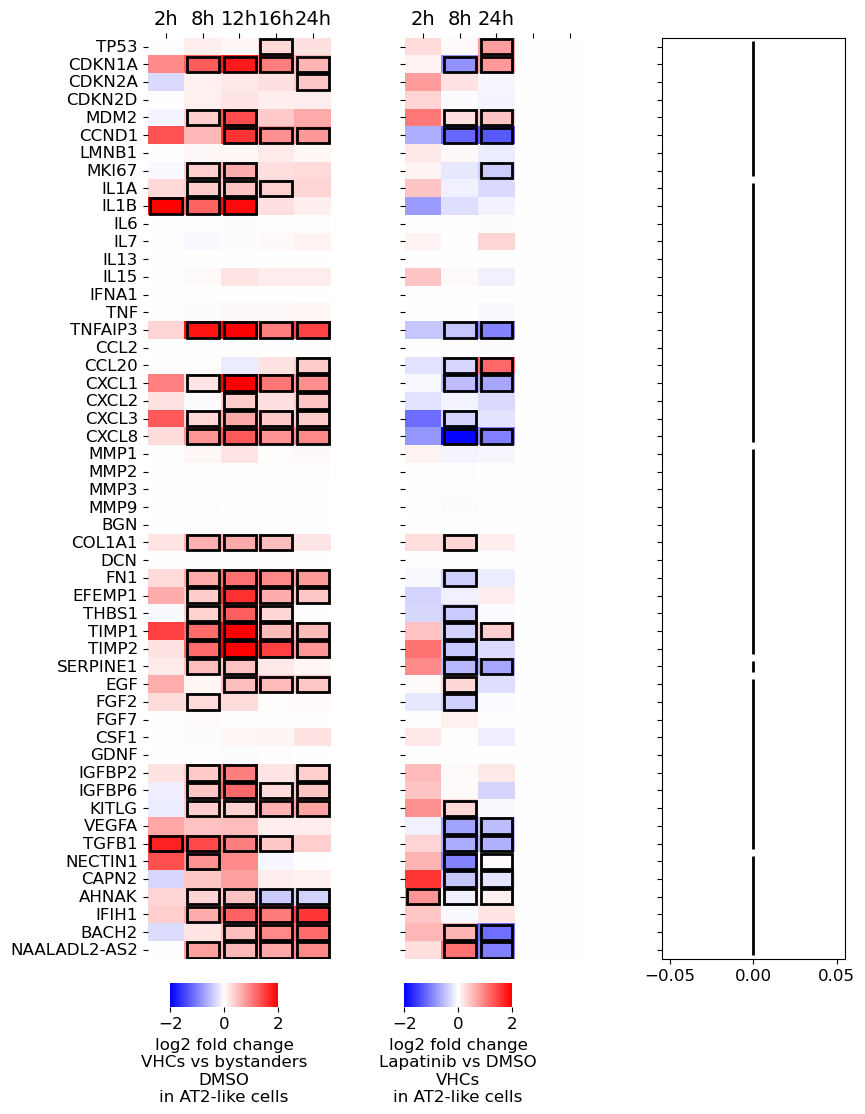

In [222]:
title = ''
genes = ['Tp53', 'Cdkn1a', 'Cdkn2a', 'Cdkn2d', 'Mdm2', 'Ccnd1', 'LMNB1', 'MKI67', 'IL1A', 'IL1B', 'IL6', 'IL7', 'IL13', 'IL15', 'IFNA1', 'IFNB1', 'IFNG', 'TNF', 'TNFAIP3', 'CCL2', 'CCL9', 'CCL20', 'CXCL1', 'CXCL2', 'CXCL3', 'CXCL8', 'MMP1', 'MMP2', 'MMP3', 'MMP9', 'BGN', 'COL1A1', 'DCN', 'FN1', 'EFEMP1', 'THBS1', 'TIMP1', 'TIMP2', 'SERPINE1', 'EGF', 'FGF2', 'FGF7', 'CSF1', 'GDNF', 'IGFBP2', 'IGFBP6', 'KITLG', 'CTGF', 'VEGFA', 'TGFB1', 'NECTIN1', 'CAPN2', 'AHNAK', 'IFIH1', 'BACH2', 'NAALADL2-AS2']
genes = [x.upper() for x in genes if x.upper() in adata.var_names]
fig, axs = plt.subplots(1, 3, sharey=True, 
                        figsize=(9, len(genes)*0.23,), 
                        gridspec_kw={'wspace':0.4})


cbar_ax1 = fig.add_axes([.15, .07, .12, .02])
labels = ['2h_infected_DMSO', '8h_infected_DMSO', '12h_infected_DMSO', '16h_infected_DMSO', '24h_infected_DMSO']
tmp = log2fcs.loc[genes][labels]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=axs[0], 
            cbar=True, cbar_ax=cbar_ax1, 
            cbar_kws={'label': 'log2 fold change\nVHCs vs bystanders\nDMSO\nin AT2-like cells',
                     'orientation': 'horizontal'})
pval = df2.loc[genes][labels]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            axs[0].add_patch(
                mpl.patches.Rectangle(
                     (i+0.07, j+0.07),0.87, 0.87,
                    edgecolor='black',fill=False,lw=2
                ) )
axs[0].set_xticklabels(['2h', '8h', '12h', '16h', '24h',],fontsize=14)
axs[0].xaxis.tick_top()
axs[0].set_title('')
axs[0].set_ylabel('')
axs[0].set_xlabel('')

cbar_ax2 = fig.add_axes([.41, .07, .12, .02])
log2fcs['z1']=0
log2fcs['z2']=0
df2['z1']=1
df2['z2']=1
labels = ['2h_VHCs', '8h_VHCs', '24h_VHCs', 'z1','z2']
tmp = log2fcs.loc[genes][labels]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=axs[1], 
            cbar=True, cbar_ax=cbar_ax2, 
            cbar_kws={'label': 'log2 fold change\nLapatinib vs DMSO\nVHCs\nin AT2-like cells',
                     'orientation': 'horizontal'})
pval = df2.loc[genes][labels]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            axs[1].add_patch(
                mpl.patches.Rectangle(
                     (i+0.07, j+0.07),0.87, 0.87,
                    edgecolor='black',fill=False,lw=2
                ) )

axs[1].set_xticklabels(['2h', '8h', '24h', '', ''],fontsize=14)
axs[1].xaxis.tick_top()
axs[1].set_title('')
axs[1].set_ylabel('')
axs[1].set_xlabel('')

axs[2].vlines(x=-0., ymin=0.2, ymax=7.8, linewidth=2, color='k')
axs[2].vlines(x=-0., ymin=8.2, ymax=22.8, linewidth=2, color='k')
axs[2].vlines(x=-0., ymin=23.2, ymax=34.8, linewidth=2, color='k')
axs[2].vlines(x=-0, ymin=35.2, ymax=35.8, linewidth=2, color='k')
axs[2].vlines(x=-0., ymin=36.2, ymax=45.8, linewidth=2, color='k')
axs[2].vlines(x=-0., ymin=46.2, ymax=51.8, linewidth=2, color='k')



fig.tight_layout()
#fig.savefig(figure_path+'heatmap_autophagy_genes_4h_linewidth1_3_new_updated.svg', format="svg")
plt.show()




In [27]:
def plot_gene_expression(filtered, ct, gene, order, figsize = [2.5, 4]):
    import matplotlib.pyplot as plt
    from statannotations.Annotator import Annotator
    from matplotlib import rcParams
    rcParams['font.size']=8
    
    adata_tmp = filtered[filtered.obs.new_cell_type == ct].copy()
    df = adata_tmp.obs[['bulk_labels', 'new_cell_type']]
    df[gene] = adata_tmp[:,gene].X.A
    df.index.name = 'cellID'
    df = df.reset_index()
    
    ids = adata_tmp.obs.bulk_labels.unique()
    pairs = []
    for indx in range(len(ids)):
        for indx2 in range(indx+1, len(ids)):
            pairs.append([ids[indx], ids[indx2]])
        
    cmap = sns.color_palette('Set2', 4)
    hue_plot_params = {'data': df,
                   'x' : 'bulk_labels', 
                   'y' : gene, 
                   'order': order,
                   'zorder' : 8,
                   'boxprops': {'edgecolor':'none'}, 
                   'medianprops' : {'color':'black', 'linewidth':0.5},
                   'capprops' : {'color':'none'},
                   'palette' : ['silver', 'whitesmoke', 'silver', 'whitesmoke',], 
                   'width' : 0.8, 
                   'showfliers': False}

    fig, ax = plt.subplots(figsize=figsize)
    sns.boxplot(ax=ax, **hue_plot_params).legend(bbox_to_anchor=(1, 1))

    empty_box=False
    if empty_box:
        for i,box in enumerate([p for p in ax.patches if not p.get_label()]): 
            color = box.get_facecolor()
            box.set_edgecolor(color)
            box.set_facecolor((0, 0, 0, 0))
            # iterate over whiskers and median lines
            for j in range(5*i,5*(i+1)):
                ax.lines[j].set_color(color)

            
    sns.stripplot(data = df.dropna(), 
              x = 'bulk_labels', y = gene, order=order, 
                  zorder=10, palette=cmap,  s=2, 
                  ax=ax, edgecolor='black', linewidth=0.3, dodge=True).legend('')


    # Add annotations
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.new_plot(ax, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", comparisons_correction="BH", 
                    text_format="full", verbose=False, show_test_name=False).apply_and_annotate()

    ax.legend(loc=(1.05, 0.5))
    ax.set_ylabel(f'{gene} (log1p(CPM))', fontsize='medium')
    labels = [x.get_text() for x in ax.get_xticklabels()]
    ax.set_xticklabels(['DMSO' if 'DMSO' in x else 'Lapatinib' for x in labels], rotation=45, fontsize='medium')
    ax.set_xlabel('bystanders           VHCs    ', fontsize='medium')
    ax.set_axisbelow(True)
    #ax.grid(True)


    fig.tight_layout()
    #plt.savefig(f'{figure_path}{gene}_allpvals.svg')
    #plt.savefig(f'{figure_path}{gene}_allpvals.png')
    plt.show()
    return(fig, ax)

In [28]:
filtered = adata[adata.obs.new_cell_type == 'AT2-like cells'].copy()
filtered.obs['bystanders'] = 'low'
filtered.obs.loc[filtered.obs.viral_counts==0, 'bystanders'] = 'bystanders'
filtered.obs.loc[filtered.obs.viral_counts>3, 'bystanders'] = 'VHCs'
filtered = filtered[filtered.obs.bystanders!='low'].copy()

filtered.obs['bulk_labels'] = filtered.obs.ID.astype(str)+'-'+filtered.obs.bystanders.astype(str)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


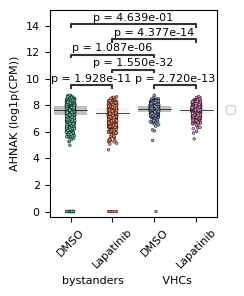

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


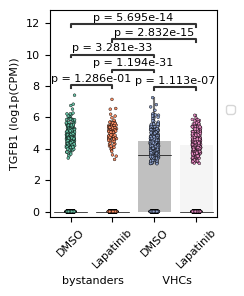

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


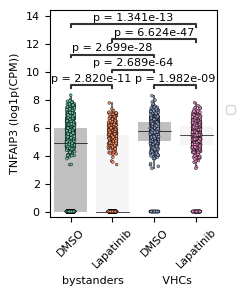

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


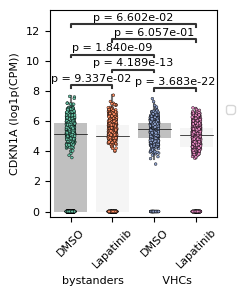

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


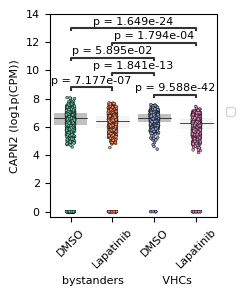

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


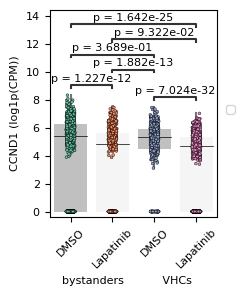

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


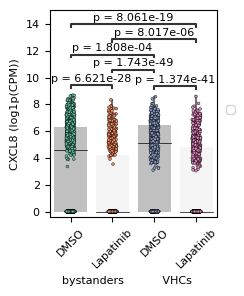

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


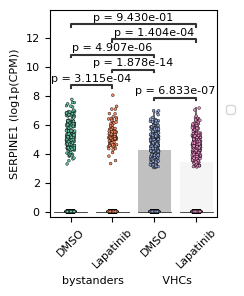

In [29]:
genes = ['AHNAK', 'TGFB1', 'TNFAIP3', 'CDKN1A', 'CAPN2', 'CCND1', 'CXCL8', 'SERPINE1']
adata_s = filtered[filtered.obs.ID.isin([
    '8h_infected_DMSO', '8h_infected_Lapatinib', #'8h_uninfected_Lapatinib',
#    '24h_infected_DMSO', '24h_infected_Lapatinib'
])]
order = ['8h_infected_DMSO-bystanders', '8h_infected_Lapatinib-bystanders', 
         '8h_infected_DMSO-VHCs', '8h_infected_Lapatinib-VHCs', 
]
for gene in genes:
    fig, ax = plot_gene_expression(adata_s, 'AT2-like cells', gene, order, figsize=[2.5, 3])
    

In [187]:
### This method masks zero expressing genes, visually clean but not correct. 
### There could be slight differences in the mean expression
def plot_gene_expression_bulk(filtered, ct, gene, order, figsize = [2.5, 4]):
    import matplotlib.pyplot as plt
    from statannotations.Annotator import Annotator
    from matplotlib import rcParams
    rcParams['font.size']=8
    
    adata_tmp = filtered[filtered.obs.new_cell_type == ct].copy()
    df = adata_tmp.obs[['bulk_labels', 'new_cell_type']]
    df[gene] = adata_tmp[:,gene].X.A
    df.index.name = 'cellID'
    df = df.reset_index()
    
    ids = adata_tmp.obs.bulk_labels.unique()
    pairs = []
    for indx in range(len(ids)):
        for indx2 in range(indx+1, len(ids)):
            pairs.append([ids[indx], ids[indx2]])
        
    cmap = sns.color_palette('Set2', 4)
    hue_plot_params = {'data': df.mask(df == 0),
                   'x' : 'bulk_labels', 
                   'y' : gene, 
                   'order': order,
                   'zorder' : 8,
                   'boxprops': {'edgecolor':'none'}, 
                   'medianprops' : {'color':'black', 'linewidth':0.5},
                   'capprops' : {'color':'none'},
                   'palette' : ['silver', 'whitesmoke', 'silver', 'whitesmoke',], 
                   'width' : 0.8, 
                   'showfliers': False}

    fig, ax = plt.subplots(figsize=figsize)
    sns.boxplot(ax=ax, **hue_plot_params).legend(bbox_to_anchor=(1, 1))

    empty_box=False
    if empty_box:
        for i,box in enumerate([p for p in ax.patches if not p.get_label()]): 
            color = box.get_facecolor()
            box.set_edgecolor(color)
            box.set_facecolor((0, 0, 0, 0))
            # iterate over whiskers and median lines
            for j in range(5*i,5*(i+1)):
                ax.lines[j].set_color(color)

            
    sns.stripplot(data = df.dropna(), 
              x = 'bulk_labels', y = gene, order=order, 
                  zorder=10, palette=cmap,  s=2, 
                  ax=ax, edgecolor='black', linewidth=0.3, dodge=True).legend('')


    # Add annotations
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.new_plot(ax, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", comparisons_correction="BH", 
                    text_format="full", verbose=False, show_test_name=False).apply_and_annotate()

    ax.legend(loc=(1.05, 0.5))
    ax.set_ylabel(f'{gene} (log1p(CPM))', fontsize='medium')
    labels = [x.get_text() for x in ax.get_xticklabels()]
    ax.set_xticklabels(['DMSO' if 'DMSO' in x else 'Lapatinib' for x in labels], rotation=45, fontsize='medium')
    ax.set_xlabel('bystanders           VHCs    ', fontsize='medium')
    ax.set_axisbelow(True)
    #ax.grid(True)


    fig.tight_layout()
    #plt.savefig(f'{figure_path}{gene}_allpvals.svg')
    #plt.savefig(f'{figure_path}{gene}_allpvals.png')
    plt.show()
    return(fig, ax)

In [185]:
filtered = adata[adata.obs.new_cell_type == 'AT2-like cells'].copy()
filtered.obs['bystanders'] = 'low'
filtered.obs.loc[filtered.obs.viral_counts==0, 'bystanders'] = 'bystanders'
filtered.obs.loc[filtered.obs.viral_counts>3, 'bystanders'] = 'VHCs'
filtered = filtered[filtered.obs.bystanders!='low'].copy()

filtered.obs['bulk_labels'] = filtered.obs.ID.astype(str)+'-'+filtered.obs.bystanders.astype(str)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


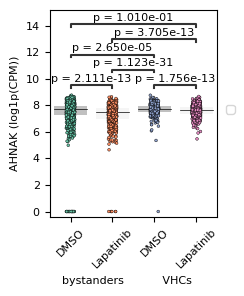

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


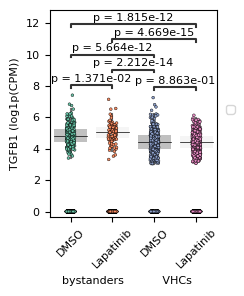

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


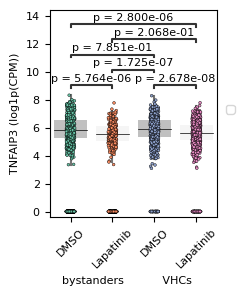

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


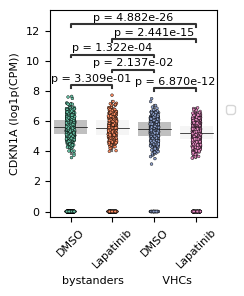

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


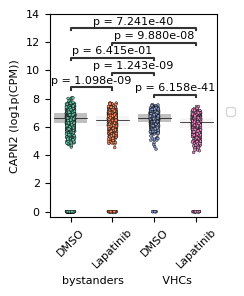

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


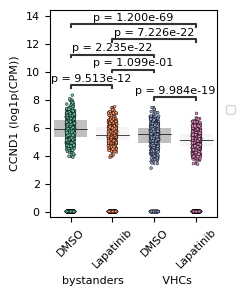

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


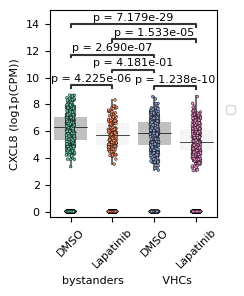

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


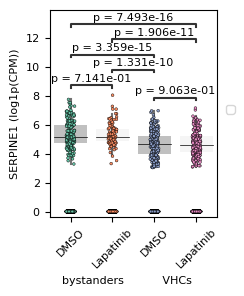

In [223]:
genes = ['AHNAK', 'TGFB1', 'TNFAIP3', 'CDKN1A', 'CAPN2', 'CCND1', 'CXCL8', 'SERPINE1']
adata_s = filtered[filtered.obs.ID.isin([
    '8h_infected_DMSO', '8h_infected_Lapatinib', #'8h_uninfected_Lapatinib',
#    '24h_infected_DMSO', '24h_infected_Lapatinib'
])]
order = ['8h_infected_DMSO-bystanders', '8h_infected_Lapatinib-bystanders', 
         '8h_infected_DMSO-VHCs', '8h_infected_Lapatinib-VHCs', 
]
for gene in genes:
    fig, ax = plot_gene_expression_bulk(adata_s, 'AT2-like cells', gene, order, figsize=[2.5, 3])
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


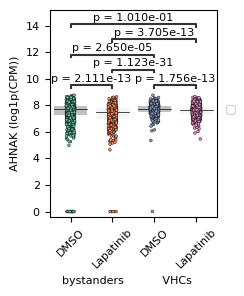

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


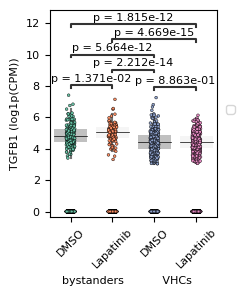

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


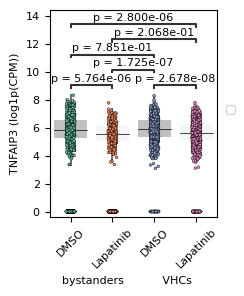

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


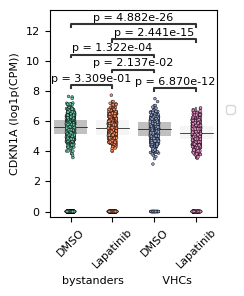

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


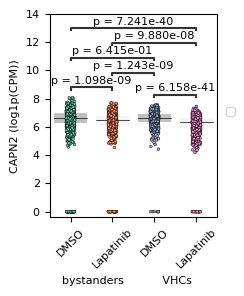

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


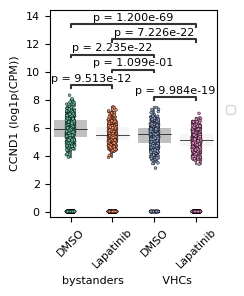

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


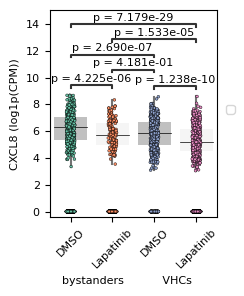

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


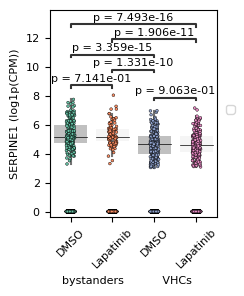

In [188]:
genes = ['AHNAK', 'TGFB1', 'TNFAIP3', 'CDKN1A', 'CAPN2', 'CCND1', 'CXCL8', 'SERPINE1']
adata_s = filtered[filtered.obs.ID.isin([
#    '8h_infected_DMSO', '8h_infected_Lapatinib', #'8h_uninfected_Lapatinib',
    '24h_infected_DMSO', '24h_infected_Lapatinib'
])]
order = ['24h_infected_DMSO-bystanders', '24h_infected_Lapatinib-bystanders', 
         '24h_infected_DMSO-VHCs', '24h_infected_Lapatinib-VHCs', 
]
for gene in genes:
    fig, ax = plot_gene_expression_bulk(adata_s, 'AT2-like cells', gene, order, figsize=[2.5, 3])
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


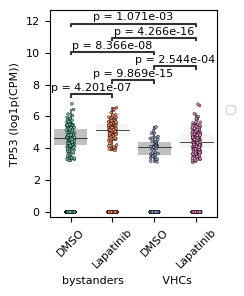

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


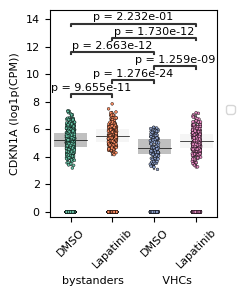

In [195]:
genes = ['TP53', 'CDKN1A']
adata_s = filtered[filtered.obs.ID.isin([
#    '8h_infected_DMSO', '8h_infected_Lapatinib', #'8h_uninfected_Lapatinib',
    '24h_infected_DMSO', '24h_infected_Lapatinib'
])]
order = ['24h_infected_DMSO-bystanders', '24h_infected_Lapatinib-bystanders', 
         '24h_infected_DMSO-VHCs', '24h_infected_Lapatinib-VHCs', ]
for gene in genes:
    fig, ax = plot_gene_expression_bulk(adata_s, 'AT2-like cells', gene, order, figsize=[2.5, 3])
    

In [224]:
def boxplot_from_log2FC(log2FCs, title='all_cell_types', xlim=3, 
                        cbar_label= 'log2 fold change \n(VHCs vs bystanders)\n24h_infected_DMSO', 
                        height=5, aspect = 0.5, vmin=-1.5, vmax = 1.5):
    fig, ax = plt.subplots(figsize=[height*aspect, height])
    cmap = sns.diverging_palette(245, 5, as_cmap=True)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

    palette = [cmap(norm(x)) for x in np.clip(log2FCs.median(axis=0), vmin, vmax)]
    sns.boxplot(data=log2FCs, orient="h", ax=ax, palette=palette)
    ax.set_title(title)
    ax.set_xlim(xlim*-1, xlim)
    ax.tick_params(labelsize=12)
    #ax.set_xticks([str(x) for x in np.linspace(vmin,vmax,1)])
    for x in [-1, 0, 1]:
        ax.axvline(x, c='black', ls='-.', lw=0.5, zorder=0.5)
    
    ax_cb = fig.add_axes([0.15, 0.04, 0.65, 0.02])
    cbar = matplotlib.colorbar.ColorbarBase(ax_cb, norm=norm, cmap=cmap, orientation='horizontal')
    cbar.set_ticks(list(range(vmin, vmax+1, 1)))
    cbar.set_ticklabels([str(x) for x in list(range(vmin, vmax+1, 1))])
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label)

    return fig, ax
#fig.tight_layout()
#data_path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/'
#fig.savefig(data_path + 'results/figures/24h_infected_RMC113_box_DEGs_VHCs_autophagy_more_than_3vRNAs.pdf', bbox_inches='tight')

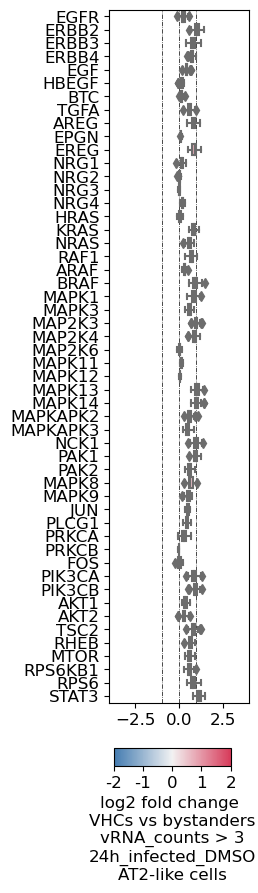

In [227]:
genes = ['EGFR', 'ERBB2', 'ERBB3', 'ERBB4', 'EGF', 'HBEGF', 'BTC', 'TGFA', 'AREG', 'EPGN', 'EREG',     
                       'NRG1', 'NRG2', 'NRG3', 'NRG4', 
        'HRAS', 'KRAS', 'NRAS', 'RAF1', 'ARAF', 'BRAF', 'MAPK1', 'MAPK3', 
         'MAP2K3', 'MAP2K4', 'MAP2K6', 'MAPK11', 'MAPK12', 'MAPK13', 'MAPK14', 'MAPKAPK2', 'MAPKAPK3',
                       'NCK1', 'PAK1', 'PAK2', 'MAPK8', 'MAPK9', 'JUN', 'PLCG1', 'PRKCA', 'PRKCB', 'AP1', 
         'FOS', 'PIK3CA', 'PIK3CB', 'AKT1', 'AKT2', 'TSC2', 'RHEB', 'MTOR', 'RPS6KB1', 'RPS6', 
         'JAK', 'STAT3',
         ]
genes = [x for x in genes if x in adata.var_names]


## change the vRNA_count to 0 to select all the cells that has any number of vRNA reads (>0)
## chenge it to 3 to select VHCs that contain more than 3 vRNA reads (>3)
from matplotlib import rcParams
rcParams['font.size']=12

ct = 'AT2-like cells'
adata_ct = adata[adata.obs.new_cell_type==ct]

cond='bystanders'
samp='DMSO'
sample1 = '24h_infected_DMSO'
n_sample = 0
vRNA_count = 3

adata_1 = adata_ct[adata_ct.obs.ID.str.startswith(sample1)].copy()
adata1 = adata_1[(adata_1.obs.viral_counts>vRNA_count)]
adata2 = adata_1[adata_1.obs.bystanders == 'zero']

log2fc_temp = sample_and_compare(adata1, adata2, n_sample=n_sample, n=100, pseudocount=False)
fig, ax = boxplot_from_log2FC(log2fc_temp[genes], xlim=4, vmin=-2, vmax=2,
                              title='',
                              height=9, aspect = 0.20, 
                              cbar_label= f'log2 fold change \nVHCs vs {cond}\nvRNA_counts > {vRNA_count}\n{sample1}\n{ct}',
                             )
plt.show()
#fig.savefig(path + f'boxplot_autophagy_genes_AT2_VHCs_vs_{cond}_{samp}_{n_sample}_new_vRNA_2.svg', 
#            bbox_inches='tight')




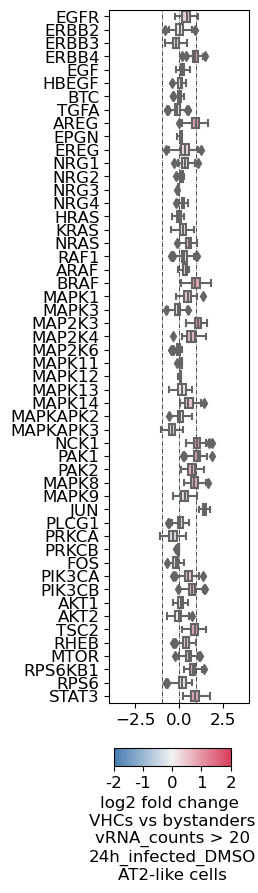

In [250]:
genes = ['EGFR', 'ERBB2', 'ERBB3', 'ERBB4', 'EGF', 'HBEGF', 'BTC', 'TGFA', 'AREG', 'EPGN', 'EREG',     
                       'NRG1', 'NRG2', 'NRG3', 'NRG4', 
        'HRAS', 'KRAS', 'NRAS', 'RAF1', 'ARAF', 'BRAF', 'MAPK1', 'MAPK3', 
         'MAP2K3', 'MAP2K4', 'MAP2K6', 'MAPK11', 'MAPK12', 'MAPK13', 'MAPK14', 'MAPKAPK2', 'MAPKAPK3',
                       'NCK1', 'PAK1', 'PAK2', 'MAPK8', 'MAPK9', 'JUN', 'PLCG1', 'PRKCA', 'PRKCB', 'AP1', 
         'FOS', 'PIK3CA', 'PIK3CB', 'AKT1', 'AKT2', 'TSC2', 'RHEB', 'MTOR', 'RPS6KB1', 'RPS6', 
         'JAK', 'STAT3',
         ]
genes = [x for x in genes if x in adata.var_names]


## change the vRNA_count to 0 to select all the cells that has any number of vRNA reads (>0)
## chenge it to 3 to select VHCs that contain more than 3 vRNA reads (>3)
from matplotlib import rcParams
rcParams['font.size']=12

ct = 'AT2-like cells'
adata_ct = adata[adata.obs.new_cell_type==ct]

cond='bystanders'
samp='DMSO'
sample1 = '24h_infected_DMSO'
n_sample = 0
vRNA_count = 20

adata_1 = adata_ct[adata_ct.obs.ID.str.startswith(sample1)].copy()
adata1 = adata_1[(adata_1.obs.viral_counts>vRNA_count)]
adata2 = adata_1[adata_1.obs.bystanders == 'zero']

log2fc_temp = sample_and_compare(adata1, adata2, n_sample=n_sample, n=100, pseudocount=False)
fig, ax = boxplot_from_log2FC(log2fc_temp[genes], xlim=4, vmin=-2, vmax=2,
                              title='',
                              height=9, aspect = 0.20, 
                              cbar_label= f'log2 fold change \nVHCs vs {cond}\nvRNA_counts > {vRNA_count}\n{sample1}\n{ct}',
                             )
plt.show()
#fig.savefig(path + f'boxplot_autophagy_genes_AT2_VHCs_vs_{cond}_{samp}_{n_sample}_new_vRNA_2.svg', 
#            bbox_inches='tight')




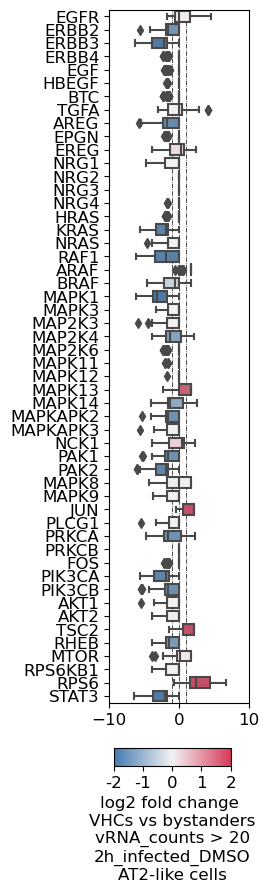

In [255]:
genes = ['EGFR', 'ERBB2', 'ERBB3', 'ERBB4', 'EGF', 'HBEGF', 'BTC', 'TGFA', 'AREG', 'EPGN', 'EREG',     
                       'NRG1', 'NRG2', 'NRG3', 'NRG4', 
        'HRAS', 'KRAS', 'NRAS', 'RAF1', 'ARAF', 'BRAF', 'MAPK1', 'MAPK3', 
         'MAP2K3', 'MAP2K4', 'MAP2K6', 'MAPK11', 'MAPK12', 'MAPK13', 'MAPK14', 'MAPKAPK2', 'MAPKAPK3',
                       'NCK1', 'PAK1', 'PAK2', 'MAPK8', 'MAPK9', 'JUN', 'PLCG1', 'PRKCA', 'PRKCB', 'AP1', 
         'FOS', 'PIK3CA', 'PIK3CB', 'AKT1', 'AKT2', 'TSC2', 'RHEB', 'MTOR', 'RPS6KB1', 'RPS6', 
         'JAK', 'STAT3',
         ]
genes = [x for x in genes if x in adata.var_names]


## change the vRNA_count to 0 to select all the cells that has any number of vRNA reads (>0)
## chenge it to 3 to select VHCs that contain more than 3 vRNA reads (>3)
from matplotlib import rcParams
rcParams['font.size']=12

ct = 'AT2-like cells'
adata_ct = adata[adata.obs.new_cell_type==ct]

cond='bystanders'
samp='DMSO'
sample1 = '2h_infected_DMSO'
n_sample = 0
vRNA_count = 20

adata_1 = adata_ct[adata_ct.obs.ID.str.startswith(sample1)].copy()
adata1 = adata_1[(adata_1.obs.viral_counts>vRNA_count)]
adata2 = adata_1[adata_1.obs.bystanders == 'zero']

log2fc_temp = sample_and_compare(adata1, adata2, n_sample=n_sample, n=100, pseudocount=False)
fig, ax = boxplot_from_log2FC(log2fc_temp[genes], xlim=10, vmin=-2, vmax=2,
                              title='',
                              height=9, aspect = 0.20, 
                              cbar_label= f'log2 fold change \nVHCs vs {cond}\nvRNA_counts > {vRNA_count}\n{sample1}\n{ct}',
                             )
plt.show()
#fig.savefig(path + f'boxplot_autophagy_genes_AT2_VHCs_vs_{cond}_{samp}_{n_sample}_new_vRNA_2.svg', 
#            bbox_inches='tight')




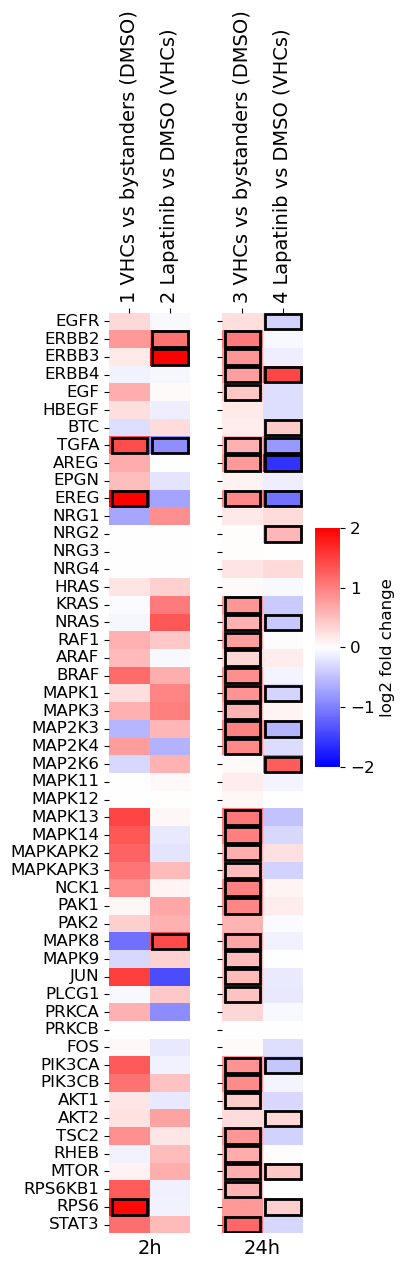

In [230]:
plt.rcParams['font.size']= 12
genes = ['EGFR', 'ERBB2', 'ERBB3', 'ERBB4', 'EGF', 'HBEGF', 'BTC', 'TGFA', 'AREG', 'EPGN', 'EREG',     
                       'NRG1', 'NRG2', 'NRG3', 'NRG4', 
        'HRAS', 'KRAS', 'NRAS', 'RAF1', 'ARAF', 'BRAF', 'MAPK1', 'MAPK3', 
         'MAP2K3', 'MAP2K4', 'MAP2K6', 'MAPK11', 'MAPK12', 'MAPK13', 'MAPK14', 'MAPKAPK2', 'MAPKAPK3',
                       'NCK1', 'PAK1', 'PAK2', 'MAPK8', 'MAPK9', 'JUN', 'PLCG1', 'PRKCA', 'PRKCB', 'AP1', 
         'FOS', 'PIK3CA', 'PIK3CB', 'AKT1', 'AKT2', 'TSC2', 'RHEB', 'MTOR', 'RPS6KB1', 'RPS6', 
         'JAK', 'STAT3',
         ]
genes = [x for x in genes if x in adata.var_names]

title = ''
labels = ['2h_infected_DMSO', '2h_VHCs',
          '24h_infected_DMSO', '24h_VHCs']

fig, axs = plt.subplots(1, 2, sharey=True, 
                        figsize=(2.5, len(genes)*0.23,), 
                        gridspec_kw={'wspace':0.4})
cbar_ax = fig.add_axes([.95, .5, .1, .2])


l = labels[:2]
tmp = log2fcs.loc[genes][l]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=axs[0], 
            cbar=True, cbar_ax=cbar_ax, cbar_kws={'label': 'log2 fold change'})
pval = df2.loc[genes][l]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            axs[0].add_patch(
                mpl.patches.Rectangle(
                     (i+0.07, j+0.07),0.87, 0.87,
                    edgecolor='black',fill=False,lw=2
                ) )


axs[0].set_xticklabels(['1 VHCs vs bystanders (DMSO)', '2 Lapatinib vs DMSO (VHCs)',],
                       fontsize=14, rotation=90)
axs[0].xaxis.tick_top()
axs[0].set_title('')
axs[0].set_xlabel('2h', fontsize=14,)
axs[0].set_ylabel('')


l = labels[2:]
tmp = log2fcs[l].loc[genes]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=axs[1], 
            cbar=True, cbar_ax=cbar_ax, cbar_kws={'label': 'log2 fold change'})
pval = df2.loc[genes][l]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            axs[1].add_patch(
                mpl.patches.Rectangle(
                     (i+0.07, j+0.07),0.87, 0.87,
                    edgecolor='black',fill=False,lw=2
                ) )
axs[1].set_xticklabels(['3 VHCs vs bystanders (DMSO)', 
                     '4 Lapatinib vs DMSO (VHCs)',],
                       fontsize=14, rotation=90)
axs[1].xaxis.tick_top()
axs[1].set_title('')
axs[1].set_xlabel('24h', fontsize=14,)
axs[1].set_ylabel('')


fig.tight_layout()
#fig.savefig(figure_path+'heatmap_autophagy_genes_4h_linewidth1_3_new_updated.svg', format="svg")
plt.show()


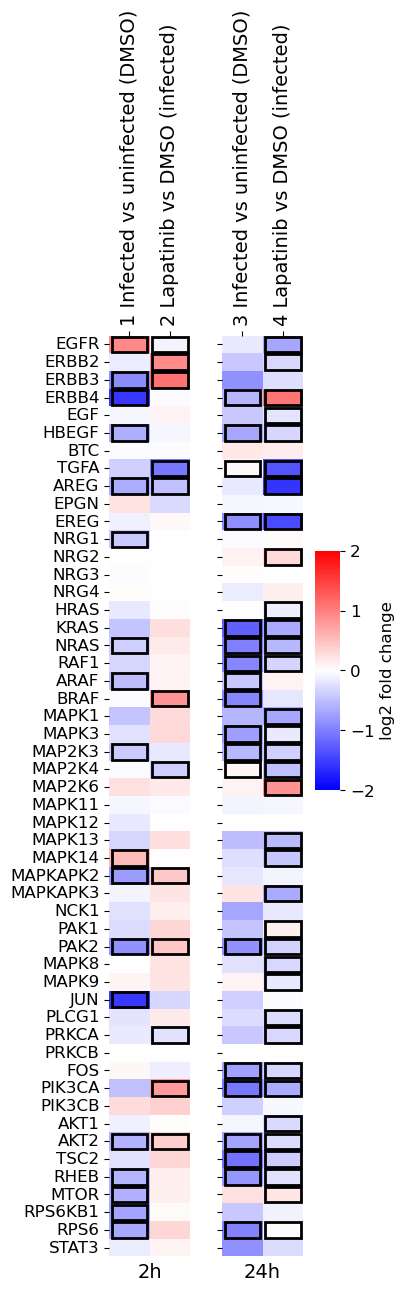

In [228]:
plt.rcParams['font.size']= 12
genes = ['EGFR', 'ERBB2', 'ERBB3', 'ERBB4', 'EGF', 'HBEGF', 'BTC', 'TGFA', 'AREG', 'EPGN', 'EREG',     
                       'NRG1', 'NRG2', 'NRG3', 'NRG4', 
        'HRAS', 'KRAS', 'NRAS', 'RAF1', 'ARAF', 'BRAF', 'MAPK1', 'MAPK3', 
         'MAP2K3', 'MAP2K4', 'MAP2K6', 'MAPK11', 'MAPK12', 'MAPK13', 'MAPK14', 'MAPKAPK2', 'MAPKAPK3',
                       'NCK1', 'PAK1', 'PAK2', 'MAPK8', 'MAPK9', 'JUN', 'PLCG1', 'PRKCA', 'PRKCB', 'AP1', 
         'FOS', 'PIK3CA', 'PIK3CB', 'AKT1', 'AKT2', 'TSC2', 'RHEB', 'MTOR', 'RPS6KB1', 'RPS6', 
         'JAK', 'STAT3',
         ]
genes = [x for x in genes if x in adata.var_names]

title = ''
labels = ['2h_infected_DMSO-2h_uninfected_DMSO',
          '2h_infected_Lapatinib-2h_infected_DMSO',
          '24h_infected_DMSO-24h uninfected DMSO',
          '24h_infected_Lapatinib-24h_infected_DMSO',
         ]

fig, axs = plt.subplots(1, 2, sharey=True, 
                        figsize=(2.5, len(genes)*0.23,), 
                        gridspec_kw={'wspace':0.4})
cbar_ax = fig.add_axes([.95, .5, .1, .2])


l = labels[:2]
tmp = log2fcs.loc[genes][l]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=axs[0], 
            cbar=True, cbar_ax=cbar_ax, cbar_kws={'label': 'log2 fold change'})
pval = df2.loc[genes][l]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            axs[0].add_patch(
                mpl.patches.Rectangle(
                     (i+0.07, j+0.07),0.87, 0.87,
                    edgecolor='black',fill=False,lw=2
                ) )


axs[0].set_xticklabels(['1 Infected vs uninfected (DMSO)', '2 Lapatinib vs DMSO (infected)',],
                       fontsize=14, rotation=90)
axs[0].xaxis.tick_top()
axs[0].set_title('')
axs[0].set_xlabel('2h', fontsize=14,)
axs[0].set_ylabel('')


l = labels[2:]
tmp = log2fcs[l].loc[genes]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=axs[1], 
            cbar=True, cbar_ax=cbar_ax, cbar_kws={'label': 'log2 fold change'})
pval = df2.loc[genes][l]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            axs[1].add_patch(
                mpl.patches.Rectangle(
                     (i+0.07, j+0.07),0.87, 0.87,
                    edgecolor='black',fill=False,lw=2
                ) )
axs[1].set_xticklabels(['3 Infected vs uninfected (DMSO)', 
                     '4 Lapatinib vs DMSO (infected)',],
                       fontsize=14, rotation=90)
axs[1].xaxis.tick_top()
axs[1].set_title('')
axs[1].set_xlabel('24h', fontsize=14,)
axs[1].set_ylabel('')


fig.tight_layout()
#fig.savefig(figure_path+'heatmap_autophagy_genes_4h_linewidth1_3_new_updated.svg', format="svg")
plt.show()
